In [1]:
import os
import numpy as np
import pandas as pd 
import seaborn as sns
import colorcet as cc
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')


warnings.filterwarnings('ignore', module='statsmodels')

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import kpss

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact


In [3]:
%%javascript
(function(on) {
    const e = $("<a>Setup failed</a>");
    const ns = "js_jupyter_suppress_warnings";
    var cssrules = $("#" + ns);
    if(!cssrules.length)
        cssrules = $("<style id='" + ns + "' type='text/css'>div.output_stderr { } </style>").appendTo("head");
    e.click(function() {
        var s = 'Showing';
        cssrules.empty()
        if(on) {
            s = 'Hiding';
            cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
        }
        e.text(s + ' warnings (click to toggle)');
        on = !on;
    }).click();
    $(element).append(e);
})(true);

<IPython.core.display.Javascript object>

In [4]:
def custom_cross_validation(X, y, model, cv=5, binary_columns = None ):
    """
    Perform cross-validation using train-test split.

    Parameters:
    - X: Features
    - y: Target variable
    - model: Machine learning model
    - cv: Number of folds for cross-validation

    Returns:
    - Array of cross-validation scores
    """

    # Get the number of samples
    num_samples = len(X)

    # Calculate the size of each fold
    fold_size = num_samples // cv

    # Initialize an array to store cross-validation scores
    cv_scores = []
    cv_predictions = np.empty_like(y)

    # Perform cross-validation
    for i in range(cv):
        # Determine the start and end indices for the current fold
        start_idx = i * fold_size
        end_idx = (i + 1) * fold_size if i < cv - 1 else num_samples

        # Split the data into training and testing sets
        X_train = np.array(np.concatenate([X[:start_idx], X[end_idx:]]))
        y_train = np.array(np.concatenate([y[:start_idx], y[end_idx:]]))
        X_test = np.array(X[start_idx:end_idx])
        y_test = np.array(y[start_idx:end_idx])

        #scale the data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        
        #columns to keep as binary
        if binary_columns is not None:
            X_train_scaled[:, binary_columns] = X_train[:, binary_columns]
            X_test_scaled[:, binary_columns] = X_test[:, binary_columns]
            
            
        
        # Fit the model on the training data
        model.fit(X_train_scaled, y_train)

        # Evaluate the model on the test data and store the score
        score = model.score(X_test_scaled, y_test)
        cv_scores.append(score)
        
        # Make predictions on the current fold and store them
        fold_predictions =  model.predict(X_test_scaled)  # You can adjust cv if needed
        cv_predictions[start_idx:end_idx] = fold_predictions

    print(f"Mean Accuracy: {np.mean(np.array(cv_scores))* 100:.2f}%" )
    return cv_predictions

In [5]:
folder_path = 'BPData'

In [6]:
def calculate_fun(patients_df, selected_columns, function, prefix):
    # Define an empty DataFrame with the specified index and columns
    df_results = pd.DataFrame(index=patients_df.index, columns=[item + prefix   for item in  selected_columns])
    for index_value in patients_df.index:
        df = patients_df.loc[index_value, 'data']
        if len(df) == 0:
            continue
        for i, column in enumerate(selected_columns):
            result = function(df[selected_columns[i]])
            df_results.loc[index_value,  selected_columns[i] + prefix]  = result
    return df_results.apply(pd.to_numeric, errors='coerce')

In [7]:
def calculate_stat(patients_df, selected_columns, function, prefix):
    # Define an empty DataFrame with the specified index and columns
    df_results = pd.DataFrame(index=patients_df.index, columns=[prefix + item for item in  selected_columns])
    for index_value in patients_df.index:
        df = patients_df.loc[index_value, 'data']
        if len(df) == 0:
            continue
        for i, column in enumerate(selected_columns):
            result = function(df[selected_columns[i]])[1]
            #if p_value > 0.1:
            #    result = 0
            #else:
            #    result = 1  
            df_results.loc[index_value, prefix + selected_columns[i]] = result
    return df_results.apply(pd.to_numeric, errors='coerce')

## Data Cleaning and Processing 

In [8]:
patient_ids = []
data_frames = []
for file_name in os.listdir(folder_path):
    if file_name.endswith('.xlsx'):
        if file_name == 'NormalizedData.xlsx':
            continue
        else:
            patient_id = str(file_name.split('_')[0])
            patient_ids.append(patient_id)
            file_path = os.path.join(folder_path, file_name)
        # Read the XLSX file into a DataFrame and append it to the list
            data_frame = pd.read_excel(file_path)
            data_frames.append(data_frame)

In [9]:
first_day_dfs = []
number_of_readings = []
for df in data_frames:
    mask = (df['Relative Date'] >= 0)& (df['Relative Date'] <= 1)
    isolated_entries = df[mask]
    first_day_dfs.append(isolated_entries)
    number_of_readings.append(len(isolated_entries))

In [10]:
num_readings_df = pd.DataFrame(number_of_readings, index=patient_ids, columns= ['num_readings'])
num_readings_df.index.name = 'Scan_ID'

In [11]:
data_dict = dict(zip(patient_ids, first_day_dfs))

In [12]:
patiendts_outcomes_df =  pd.read_excel('ML_Data_filtered.xlsx' )

In [13]:
patients_df = pd.merge(patiendts_outcomes_df, num_readings_df, on='Scan_ID', how='inner')

In [14]:
patients_df.set_index('Scan_ID', inplace=True)

In [15]:
patients_df  = patients_df.assign(data=pd.Series(data_dict))

In [16]:
patients_df =  patients_df.loc[patients_df['num_readings'] > 0]

In [17]:
patients_df['y'] = patients_df['Label'].apply(lambda x: 0 if x == 2 else 1)


In [18]:
patients_df = patients_df.drop(['KK36', 'KK32'])

In [19]:
## 0 is Degeneration, 1 is Remodeling
patients_df['condition'] = patients_df['y'].apply(lambda x: 'Degeneration' if x == 0 else 'Remodeling')
patients_df[['condition']].value_counts()

condition   
Remodeling      17
Degeneration    14
Name: count, dtype: int64

## Calculating Basic Statistics

In [20]:
df_mean = calculate_fun(patients_df, ['SBP', 'DBP', 'PP'],np.mean, ' mean')
df_mean.index.name = 'ID'

In [21]:
patients_df = pd.merge(patients_df, df_mean, on='ID', how='inner')

In [22]:
df_STD = calculate_fun(patients_df, ['SBP', 'DBP', 'PP'],np.std, ' std')
df_STD.index.name = 'ID'
patients_df = pd.merge(patients_df, df_STD, on='ID', how='inner')

In [23]:
df_kertosis = calculate_fun(patients_df, ['SBP', 'DBP', 'PP'],stats.kurtosis, ' kurtosis')
df_kertosis.index.name = 'ID'
patients_df = pd.merge(patients_df, df_kertosis, on='ID', how='inner')

In [24]:
df_ptp= calculate_fun(patients_df, ['SBP', 'DBP', 'PP'],np.ptp, ' range')
df_ptp.index.name = 'ID'
patients_df = pd.merge(patients_df, df_ptp, on='ID', how='inner')

## Stationarity Tests

In [25]:
df_ADF = calculate_stat(patients_df, ['SBP', 'DBP', 'PP'], adfuller, 'ADF ')
df_ADF.index.name = 'ID'
patients_df = pd.merge(patients_df, df_ADF, on='ID', how='inner')

In [26]:
df_ACF = calculate_stat(patients_df, ['SBP', 'DBP', 'PP'], acf, 'ACF ')
df_ACF.index.name = 'ID'
patients_df = pd.merge(patients_df, df_ACF, on='ID', how='inner')

In [27]:
df_KPSS = calculate_stat(patients_df, ['SBP', 'DBP', 'PP'], kpss, 'KPSS ')
df_KPSS.index.name = 'ID'
patients_df = pd.merge(patients_df, df_KPSS, on='ID', how='inner')

C:\Users\s-ami\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\s-ami\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\s-ami\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\s-ami\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is great

## Stationarity Significance and Categories

In [28]:
patients_df['significance of SBP ADF'] = (patients_df['ADF SBP']< 0.05 ).astype(int)
patients_df['significance of PP ADF'] = (patients_df['ADF PP']< 0.05 ).astype(int)
patients_df['significance of DBP ADF'] = (patients_df['ADF DBP']< 0.05 ).astype(int)

patients_df['significance of SBP KPSS'] = (patients_df['KPSS SBP']< 0.05 ).astype(int)
patients_df['significance of PP KPSS'] = (patients_df['KPSS PP']< 0.05 ).astype(int)
patients_df['significance of DBP KPSS'] = (patients_df['KPSS DBP']< 0.05 ).astype(int)

patients_df['significance of SBP ACF'] = (patients_df['ACF SBP']< 0.01 ).astype(int)
patients_df['significance of PP ACF'] = (patients_df['ACF PP']< 0.01).astype(int)
patients_df['significance of DBP ACF'] = (patients_df['ACF DBP']< 0.01 ).astype(int)


patients_df['strict significance of SBP ADF'] = (patients_df['ADF SBP']< 0.01 ).astype(int)



In [29]:
def categorize_stationarity(row):
    if row['significance of SBP ADF'] == 1 and row['significance of SBP KPSS'] == 0:
        return 'Strictly Stationary'
    elif row['significance of SBP ADF'] == 1 and row['significance of SBP KPSS'] == 1:
        return 'Trend-Stationary'
    elif row['significance of SBP ADF'] == 0 and row['significance of SBP KPSS'] == 0:
        return 'Difference-Stationary'
    else:
        return 'Non-Stationary'

In [30]:
patients_df['Stationarity_Category'] = patients_df.apply(categorize_stationarity, axis=1)

In [31]:
df_encoded = pd.get_dummies(patients_df['Stationarity_Category'])

# Add the binary columns to the original DataFrame
patients_df = pd.concat([patients_df, df_encoded], axis=1)

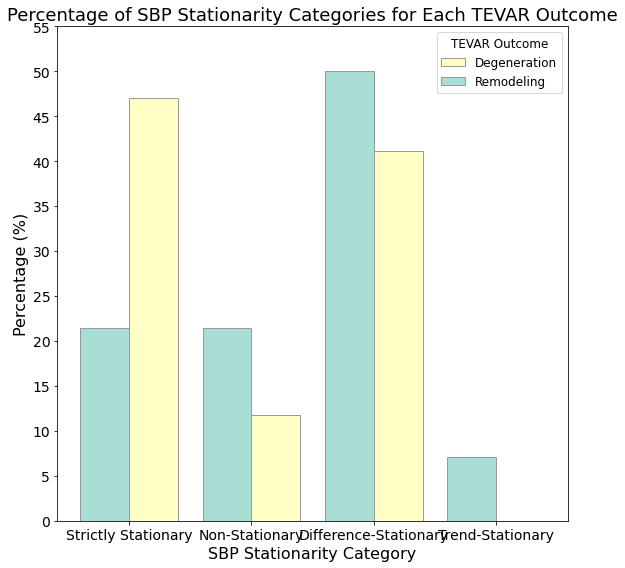

In [32]:


plt.figure(figsize=(8, 8))

# Calculate total counts within each condition category
total_counts = patients_df.groupby('condition')['Stationarity_Category'].count()

# Create a normalized histogram with customized legend labels
legend_labels = {'Degeneration': 'Good', 'Remodeling': 'Bad'}

# Plot the histogram
ax = sns.histplot(x='Stationarity_Category', hue='condition', data=patients_df, palette="Set3", 
                  stat="percent", common_norm=False, element="bars",  
                  edgecolor=".6", shrink=0.8, multiple="dodge", hue_order=['Degeneration', 'Remodeling'], 
                  weights=patients_df['condition'].map(lambda x: 1 / total_counts[x]))

plt.title('Percentage of SBP Stationarity Categories for Each TEVAR Outcome', fontsize=18)
plt.xlabel('SBP Stationarity Category', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=16)
plt.legend(title='TEVAR Outcome', title_fontsize='12', fontsize='12', labels=['Degeneration', 'Remodeling'])
plt.yticks(np.arange(0, 60, 5), fontsize=14)

# Manually adjust x ticks position
num_categories = patients_df['Stationarity_Category'].nunique()
tick_positions = np.arange(num_categories)

# Set x ticks
ax.set_xticks(tick_positions)

# Set x tick labels centered below ticks
ax.set_xticklabels(patients_df['Stationarity_Category'].unique(), rotation=0, ha='center', fontsize=14)

plt.tight_layout()
plt.savefig('SBP_stationarity.png', dpi=600)
plt.show()

## SBP basic Statistics 

In [33]:
mean_values_by_label = patients_df[['SBP mean', 'SBP std', 'SBP kurtosis','SBP range', 'y']].groupby('y').mean()

In [34]:
mean_values_by_label

,SBP mean,SBP std,SBP kurtosis,SBP range
y,,,,
0,128.111601,12.091961,0.595731,47.285714
1,131.075700,12.560644,0.172562,47.294118


## Two-tailed t-test and Pearson correlation for basic statistics

In [35]:
good_outcome_df = patients_df.loc[patients_df['y'] == 1]
bad_outcome_df = patients_df.loc[patients_df['y'] == 0] 

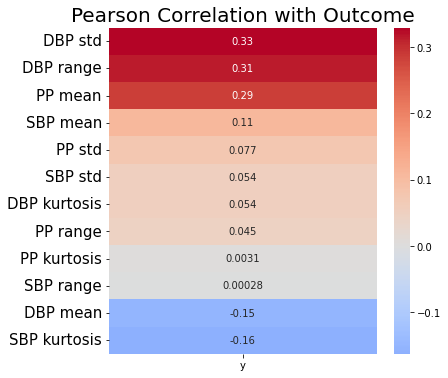

In [36]:
axis_font = {'fontname':'Arial', 'size':'14'}

columns_to_test =  ['SBP mean', 'DBP mean', 'PP mean', 'SBP std', 'DBP std', 'PP std',
       'SBP kurtosis', 'DBP kurtosis', 'PP kurtosis', 'SBP range', 'DBP range',
       'PP range', 'y']
correlation_matrix = patients_df[columns_to_test].corr(method='pearson')
target_correlations = correlation_matrix['y'].drop(['y' ]).sort_values(ascending=False)

target_correlations = target_correlations[columns_to_test[:-1]].sort_values(ascending=False)


# Create a correlation plot using Seaborn's heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(target_correlations.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.yticks(fontsize=15)
plt.rcParams.update({'font.size': 14})
plt.title(f'Pearson Correlation with Outcome', fontsize=20)
plt.show()

In [37]:
from scipy.stats import ttest_ind


columns_to_test =  ['SBP mean', 'DBP mean', 'PP mean', 'SBP std', 'DBP std', 'PP std',
       'SBP kurtosis', 'DBP kurtosis', 'PP kurtosis', 'SBP range', 'DBP range',
       'PP range']
alpha = 0.1

p_values = {}
for column in columns_to_test:
    values_group_0 = bad_outcome_df[column]
    values_group_1 = good_outcome_df[column]
    
    t_statistic, p_value = ttest_ind(values_group_0, values_group_1)
    p_values[column] = p_value
    
    print(f"Column: {column}")
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value)
    
    if p_value < alpha:
        print("Reject the null hypothesis: The means are different.")
    else:
        print("Fail to reject the null hypothesis: The means are not different.")
    
    print("\n")



Column: SBP mean
T-Statistic: -0.5931119675882082
P-Value: 0.557703856185095
Fail to reject the null hypothesis: The means are not different.


Column: DBP mean
T-Statistic: 0.8307195509588552
P-Value: 0.4129193800120837
Fail to reject the null hypothesis: The means are not different.


Column: PP mean
T-Statistic: -1.6137752165801076
P-Value: 0.1174064234810855
Fail to reject the null hypothesis: The means are not different.


Column: SBP std
T-Statistic: -0.29248432871503455
P-Value: 0.7719988107948791
Fail to reject the null hypothesis: The means are not different.


Column: DBP std
T-Statistic: -1.879802357357114
P-Value: 0.07021594435687702
Reject the null hypothesis: The means are different.


Column: PP std
T-Statistic: -0.41412148755148437
P-Value: 0.6818321868833984
Fail to reject the null hypothesis: The means are not different.


Column: SBP kurtosis
T-Statistic: 0.8879183278425853
P-Value: 0.3818901512283367
Fail to reject the null hypothesis: The means are not different.



## Two-tailed t-test and Pearson correlation for stationarity tests p-values

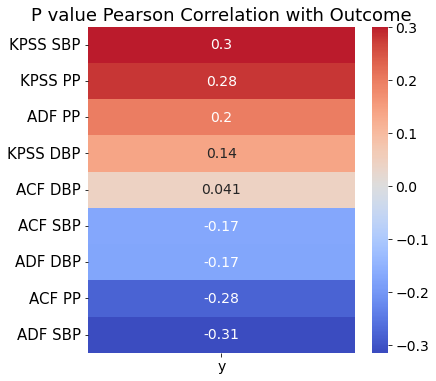

In [38]:
axis_font = {'fontname':'Arial', 'size':'14'}

columns_to_test =  ['ADF SBP', 'ADF DBP', 'ADF PP', 'KPSS SBP', 'KPSS DBP', 'KPSS PP',
       'ACF SBP', 'ACF DBP', 'ACF PP', 'y']
correlation_matrix = patients_df[columns_to_test].corr(method='pearson')
target_correlations = correlation_matrix['y'].drop(['y' ]).sort_values(ascending=False)

target_correlations = target_correlations[columns_to_test[:-1]].sort_values(ascending=False)


# Create a correlation plot using Seaborn's heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(target_correlations.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.yticks(fontsize=15)
plt.rcParams.update({'font.size': 14})
plt.title(f'P value Pearson Correlation with Outcome', fontsize=18)
plt.show()

In [39]:
p_values = {}
alpha = 0.1
columns_to_test =  ['ADF SBP', 'ADF DBP', 'ADF PP', 'KPSS SBP', 'KPSS DBP', 'KPSS PP',
       'ACF SBP', 'ACF DBP', 'ACF PP']

for column in columns_to_test:
    values_group_0 = bad_outcome_df[column]
    #values_group_0 = (values_group_0 < 0.01).astype(int)
    values_group_1 = good_outcome_df[column]
    #values_group_1 = (values_group_1 < 0.01).astype(int)
    
    t_statistic, p_value = ttest_ind(values_group_0, values_group_1)
    p_values[column] = p_value
    
    print(f"Column: {column}")
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value)
    
    if p_value < alpha:
        print("Reject the null hypothesis: The means are different.")
    else:
        print("Fail to reject the null hypothesis: The means are not different.")
    
    print("\n")

Column: ADF SBP
T-Statistic: 1.786742641326655
P-Value: 0.08443790388064422
Reject the null hypothesis: The means are different.


Column: ADF DBP
T-Statistic: 0.9546782300789309
P-Value: 0.34763119189438296
Fail to reject the null hypothesis: The means are not different.


Column: ADF PP
T-Statistic: -1.0867716811068895
P-Value: 0.28608855766233954
Fail to reject the null hypothesis: The means are not different.


Column: KPSS SBP
T-Statistic: -1.695784393114049
P-Value: 0.1006385636817785
Fail to reject the null hypothesis: The means are not different.


Column: KPSS DBP
T-Statistic: -0.7561347124689904
P-Value: 0.45566721062673166
Fail to reject the null hypothesis: The means are not different.


Column: KPSS PP
T-Statistic: -1.5716641094814283
P-Value: 0.12687656131464242
Fail to reject the null hypothesis: The means are not different.


Column: ACF SBP
T-Statistic: 0.9389547513652637
P-Value: 0.3555092373362363
Fail to reject the null hypothesis: The means are not different.


Col

## Fisher test for stationarity tests significance

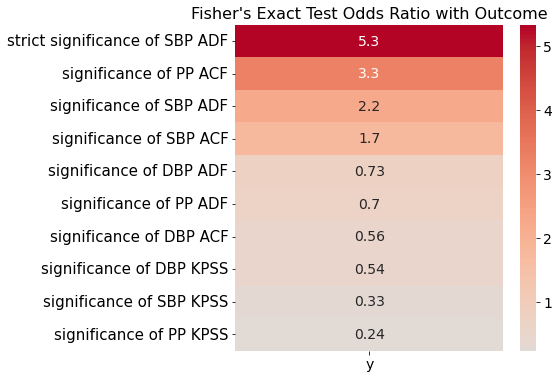

In [40]:
axis_font = {'fontname':'Arial', 'size':'14'}


columns_to_test =  ['significance of SBP ADF', 'significance of PP ADF', 'significance of DBP ADF', 'significance of SBP KPSS',
                    'significance of PP KPSS', 'significance of DBP KPSS', 'significance of SBP ACF', 
                    'significance of PP ACF', 'significance of DBP ACF',
                    'strict significance of SBP ADF', 'y']

def fisher_odds(x, y):
    
    contingency_table = pd.crosstab(x, y)
    if contingency_table.shape != (2, 2):
        return None
    
    odds_ratio, p_value = fisher_exact(contingency_table)
    
    return odds_ratio

correlation_matrix = pd.DataFrame(index=columns_to_test, columns=columns_to_test)

for var1 in columns_to_test:
    for var2 in columns_to_test:
        if var1 != var2:
            correlation_matrix.loc[var1, var2] = fisher_odds(patients_df[var1], patients_df[var2])


#orrelation_matrix = patients_df.corr(method='pearson')
target_correlations = correlation_matrix['y'].drop(['y' ]).sort_values(ascending=False)

target_correlations = target_correlations[columns_to_test[:-1]].fillna(1).sort_values(ascending=False)


# Create a correlation plot using Seaborn's heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(target_correlations.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.yticks(fontsize=15)
plt.rcParams.update({'font.size': 14})
plt.title(f'Fisher\'s Exact Test Odds Ratio with Outcome', fontsize=16)
plt.show()

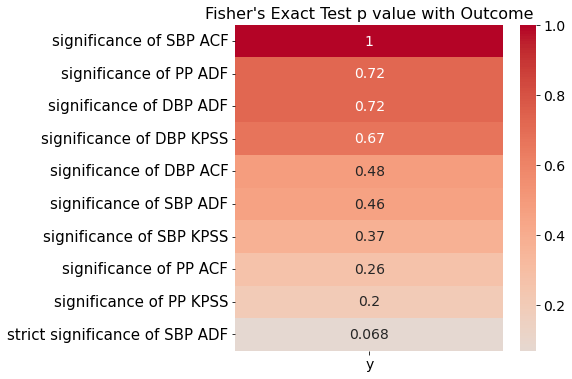

In [41]:
axis_font = {'fontname':'Arial', 'size':'14'}

columns_to_test =  ['significance of SBP ADF', 'significance of PP ADF', 'significance of DBP ADF', 'significance of SBP KPSS',
                    'significance of PP KPSS', 'significance of DBP KPSS', 'significance of SBP ACF', 
                    'significance of PP ACF', 'significance of DBP ACF', 
                    'strict significance of SBP ADF', 'y']

def fisher_p_val(x, y):
    contingency_table = pd.crosstab(x, y)
    if contingency_table.shape != (2, 2):
        return None
    odds_ratio, p_value = fisher_exact(contingency_table)
    return p_value

correlation_matrix = pd.DataFrame(index=columns_to_test, columns=columns_to_test)

for var1 in columns_to_test:
    for var2 in columns_to_test:
        if var1 != var2:
            correlation_matrix.loc[var1, var2] = fisher_p_val(patients_df[var1], patients_df[var2])


#orrelation_matrix = patients_df.corr(method='pearson')
target_correlations = correlation_matrix['y'].drop(['y' ]).sort_values(ascending=False)

target_correlations = target_correlations[columns_to_test[:-1]].fillna(1).sort_values(ascending=False)


# Create a correlation plot using Seaborn's heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(target_correlations.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.yticks(fontsize=15)
plt.rcParams.update({'font.size': 14})
plt.title(f'Fisher\'s Exact Test p value with Outcome', fontsize=16)
plt.show()

In [42]:
target_correlations

significance of SBP ACF           1.000000
significance of PP ADF            0.724707
significance of DBP ADF           0.724102
significance of DBP KPSS          0.670548
significance of DBP ACF           0.477466
significance of SBP ADF           0.460744
significance of SBP KPSS          0.369670
significance of PP ACF            0.258001
significance of PP KPSS           0.197548
strict significance of SBP ADF    0.067989
Name: y, dtype: float64

## Fisher test for stationarity subcategories

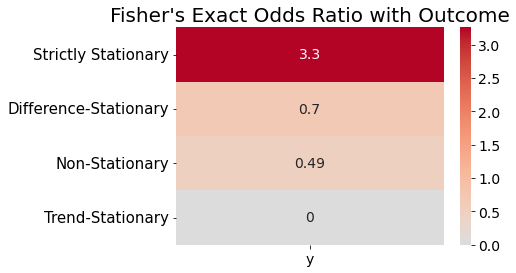

In [43]:
axis_font = {'fontname':'Arial', 'size':'14'}

columns_to_test =  [ 'Difference-Stationary','Non-Stationary',  'Strictly Stationary',
                              'Trend-Stationary', 'y']


correlation_matrix = pd.DataFrame(index=columns_to_test, columns=columns_to_test)

for var1 in columns_to_test:
    for var2 in columns_to_test:
        if var1 != var2:
            correlation_matrix.loc[var1, var2] = fisher_odds(patients_df[var1], patients_df[var2])


#orrelation_matrix = patients_df.corr(method='pearson')
target_correlations = correlation_matrix['y'].drop(['y' ]).sort_values(ascending=False)

target_correlations = target_correlations[columns_to_test[:-1]].sort_values(ascending=False).fillna(0)


# Create a correlation plot using Seaborn's heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(target_correlations.to_frame(), annot=True, cmap='coolwarm', center=0)
plt.yticks(fontsize=15)
plt.rcParams.update({'font.size': 14})
plt.title(f'Fisher\'s Exact Odds Ratio with Outcome', fontsize=20)
plt.show()

In [44]:
target_correlations

Strictly Stationary      3.259259
Difference-Stationary    0.700000
Non-Stationary           0.488889
Trend-Stationary         0.000000
Name: y, dtype: float64

## Cramer test for stationarity subcategories

In [45]:
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, p_val, _, _ = chi2_contingency(contingency_table)
    num_obs = patients_df.shape[0]
    min_dim = min(contingency_table.shape)
    v_cramer = np.sqrt(chi2 / (num_obs * (min_dim - 1)))
    return v_cramer, p_val


In [46]:
cramers_v(patients_df['Stationarity_Category'], patients_df['y'])

(0.32191415659607064, 0.3600092214221128)

# Logistic Regression models

## Baseline Model with CT scans features

In [47]:
y = np.array(patients_df['y'])
X = patients_df.drop(columns=['Label', 'y', 'num_readings', 'data', 'scan number', 'Stationarity_Category', 
                              'Difference-Stationary','Non-Stationary',  'Strictly Stationary',
                              'Trend-Stationary', 'condition'])

X_features = np.array(X[['Mean_Curvedness_Mean_Norm',  'Total_Curvature_FluctArea_Norm'  ]])
model = LogisticRegression()
cv_predictions = custom_cross_validation(X_features , y, model, cv=5, binary_columns = None )

Mean Accuracy: 74.76%


[Text(0, 0.5, 'Actual Degeneration'), Text(0, 1.5, 'Actual Remodeling')]

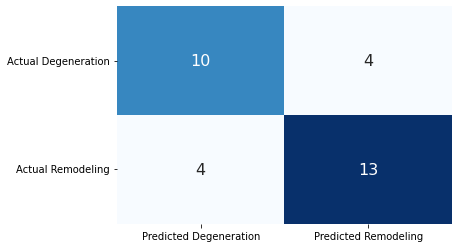

In [48]:
cm  = confusion_matrix(y, cv_predictions)

plot = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Degeneration', 'Predicted Remodeling'],
            yticklabels=['Actual Degeneration', 'Actual Remodeling'], annot_kws={"size": 16})

plot.set_xticklabels(plot.get_xticklabels(), fontsize=10)

# Increase font size of y-axis labels
plot.set_yticklabels(plot.get_yticklabels(), fontsize=10)

In [49]:
# Define the classifier
classifier = LogisticRegression()

scaler = StandardScaler()


X_scaled = scaler.fit_transform(X_features)
classifier.fit(X_scaled, y)

pred_y = classifier.predict(X_scaled)

correct_predictions = (y == pred_y).sum()
total_predictions = len(y)
accuracy = correct_predictions / total_predictions

# Display accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')



Accuracy: 77.42%


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                  10                   4
Actual Positive                   3                  14


[Text(0, 0.5, 'Actual Degeneration'), Text(0, 1.5, 'Actual Remodeling')]

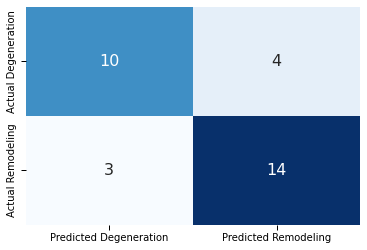

In [50]:
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":16,"axes.labelsize":14})  

cm = confusion_matrix(y, pred_y)
confusion_matrix_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("Confusion Matrix:")
print(confusion_matrix_df)
plot = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Degeneration', 'Predicted Remodeling'],
            yticklabels=['Actual Degeneration', 'Actual Remodeling'], annot_kws={"size": 16})

plot.set_xticklabels(plot.get_xticklabels(), fontsize=10)

# Increase font size of y-axis labels
plot.set_yticklabels(plot.get_yticklabels(), fontsize=10)

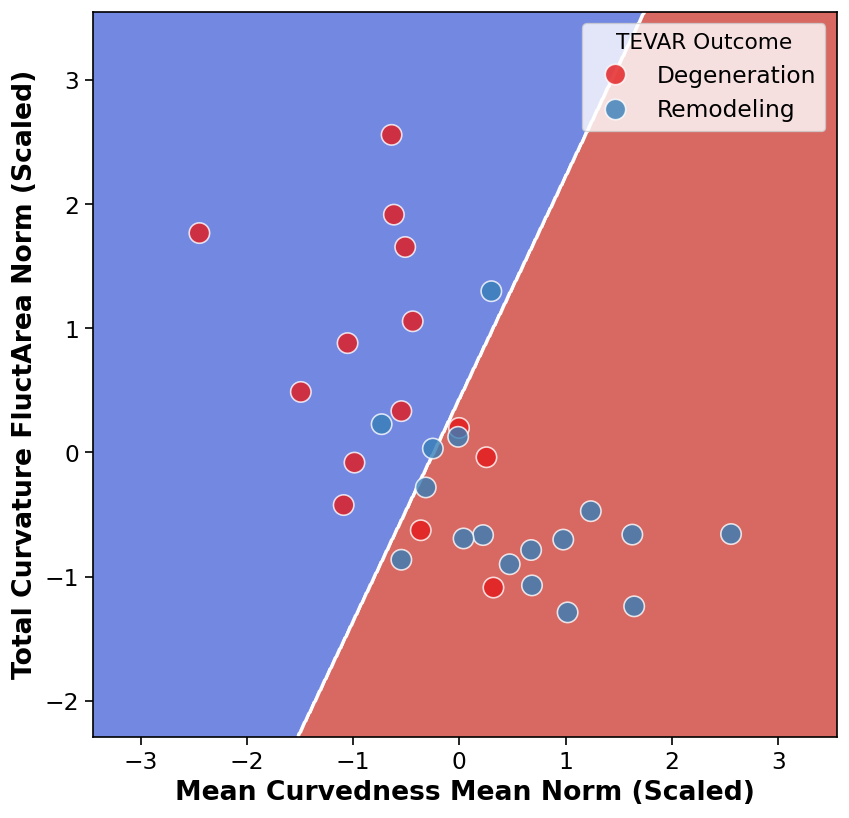

In [51]:
x_min, x_max = X_scaled[:, 0].min() - 1,  X_scaled[:, 0].max() + 1
y_min, y_max =  X_scaled[:, 1].min() - 1,  X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Use the model to predict probabilities on the mesh grid
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predicted probabilities to the shape of the mesh grid
Z = Z.reshape(xx.shape)

# Increase DPI and set figure size
plt.figure(figsize=(8, 8), dpi=120)

cmap_contour = sns.color_palette("coolwarm", as_cmap=True)
cmap_scatter = sns.color_palette("Set1")
decision_boundary = plt.contour(xx, yy, Z, levels=[0.5], colors='white', linewidths=2, zorder=2)


# Plot the contour plot
plt.contourf(xx, yy, Z, cmap=cmap_contour, alpha=0.8, linewidths=2, zorder=1)

# Scatter plot of the data points
scatter = sns.scatterplot(x = X_scaled[:, 0], y= X_scaled[:, 1], hue=y, edgecolors='white', palette='Set1', marker='o', s=150, 
            alpha= 0.8, zorder=3)

# Add labels and title with bigger font sizes
plt.ylabel('Total Curvature FluctArea Norm (Scaled)', fontsize=16, fontweight='bold')
plt.xlabel('Mean Curvedness Mean Norm (Scaled)', fontsize=16, fontweight='bold')

# Customize the legend
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Degeneration', 'Remodeling'], title='TEVAR Outcome', fontsize=14, title_fontsize='13')

# Increase font size of axis ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


# Add gridlines
plt.grid(False)


# Show the plot
plt.show()

## Overfitted Model to score features

In [52]:
X_features = np.array(X)
sig_columns=  [-9, -8, -7, -6, -5, -4 ,-3, -2, -1]
model = LogisticRegression()
cv_predictions = custom_cross_validation(X_features , y, model, cv=5, binary_columns = sig_columns)

Mean Accuracy: 70.95%


[Text(0, 0.5, 'Actual Degeneration'), Text(0, 1.5, 'Actual Remodeling')]

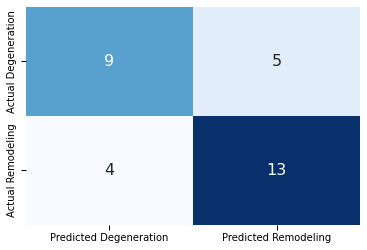

In [53]:
cm  = confusion_matrix(y, cv_predictions)

plot = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Degeneration', 'Predicted Remodeling'],
            yticklabels=['Actual Degeneration', 'Actual Remodeling'], annot_kws={"size": 16})

plot.set_xticklabels(plot.get_xticklabels(), fontsize=10)

# Increase font size of y-axis labels
plot.set_yticklabels(plot.get_yticklabels(), fontsize=10)

Accuracy: 100.00%
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                  14                   0
Actual Positive                   0                  17


[Text(0, 0.5, 'Actual Degeneration'), Text(0, 1.5, 'Actual Remodeling')]

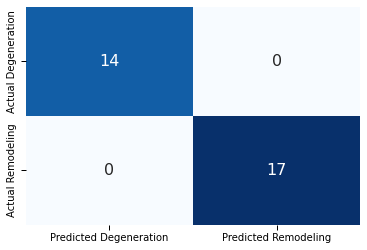

In [54]:
# Define the classifier
classifier = LogisticRegression()

scaler = StandardScaler()


X_scaled = scaler.fit_transform(X_features)
X_scaled[:, -3:] = X_features[:, -3:]
classifier.fit(X_scaled, y)

pred_y = classifier.predict(X_scaled)

correct_predictions = (y == pred_y).sum()
total_predictions = len(y)
accuracy = correct_predictions / total_predictions

# Display accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

sns.set_context("paper", rc={"font.size":14,"axes.titlesize":16,"axes.labelsize":14})  

cm = confusion_matrix(y, pred_y)
confusion_matrix_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("Confusion Matrix:")
print(confusion_matrix_df)
plot = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Degeneration', 'Predicted Remodeling'],
            yticklabels=['Actual Degeneration', 'Actual Remodeling'], annot_kws={"size": 16})

plot.set_xticklabels(plot.get_xticklabels(), fontsize=10)

# Increase font size of y-axis labels
plot.set_yticklabels(plot.get_yticklabels(), fontsize=10)

In [55]:
feature_scores = classifier.coef_[0]

# Display feature scores
    
sorted_feature_indices = abs(feature_scores).argsort()[::-1]
sorted_features = X.columns[sorted_feature_indices]
sorted_scores = feature_scores[sorted_feature_indices]

# Display sorted feature importance
for feature, score in zip(sorted_features, sorted_scores):
    print(f'{feature}: {score}')

Mean_Curvedness_Mean_Norm: 1.3486342759224226
DBP std: 0.7217546600998168
strict significance of SBP ADF: 0.670284612456548
ADF PP: 0.6468208774996272
ADF SBP: -0.6160187519019084
Total_Curvature_FluctArea_Norm: -0.6122436592820413
KPSS SBP: 0.4464124350553941
ACF DBP: 0.44198058002283325
ACF PP: -0.3835098467917417
DBP mean: -0.36673179704461006
significance of PP ADF: -0.32875192227145644
DBP range: 0.3035453804819717
PP mean: 0.29470843167030175
significance of SBP ACF: 0.26406530959349384
significance of SBP KPSS: -0.26359273227295854
DBP kurtosis: -0.26033132282510096
SBP kurtosis: -0.2427394142343752
SBP range: -0.23690140777589508
ADF DBP: -0.23610667515142372
significance of DBP ACF: -0.23121393369076984
significance of DBP ADF: -0.21704889340676883
ACF SBP: -0.21398616503864562
PP range: -0.19559554442232727
KPSS PP: -0.16337820476282414
KPSS DBP: 0.13484690121732212
significance of DBP KPSS: -0.1223727865290797
significance of SBP ADF: 0.11555439374549793
significance of PP A

### Decision boundries for models with the 'strict significance of SBP ADF' feature

In [56]:
X_features = np.array(X[['Mean_Curvedness_Mean_Norm', 'strict significance of SBP ADF']])

model = LogisticRegression()
cv_predictions = custom_cross_validation(X_features , y, model, cv=5, binary_columns = [1] )


Mean Accuracy: 84.29%


[Text(0, 0.5, 'Actual Degeneration'), Text(0, 1.5, 'Actual Remodeling')]

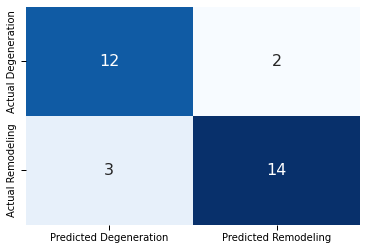

In [57]:
cm  = confusion_matrix(y, cv_predictions)

plot = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Degeneration', 'Predicted Remodeling'],
            yticklabels=['Actual Degeneration', 'Actual Remodeling'], annot_kws={"size": 16})

plot.set_xticklabels(plot.get_xticklabels(), fontsize=10)

# Increase font size of y-axis labels
plot.set_yticklabels(plot.get_yticklabels(), fontsize=10)

Accuracy: 87.10%


[Text(0, 0.5, 'Actual Degeneration'), Text(0, 1.5, 'Actual Remodeling')]

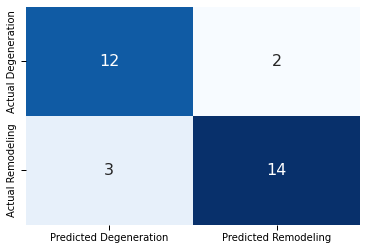

In [58]:
# Define the classifier
classifier = LogisticRegression()

scaler = StandardScaler()


X_scaled = scaler.fit_transform(X_features)
X_scaled[:, 1] = X_features[:, 1]
classifier.fit(X_scaled, y)

pred_y = classifier.predict(X_scaled)

correct_predictions = (y == pred_y).sum()
total_predictions = len(y)
accuracy = correct_predictions / total_predictions

# Display accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

sns.set_context("paper", rc={"font.size":14,"axes.titlesize":16,"axes.labelsize":14})  

cm  = confusion_matrix(y, cv_predictions)

plot = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Degeneration', 'Predicted Remodeling'],
            yticklabels=['Actual Degeneration', 'Actual Remodeling'], annot_kws={"size": 16})

plot.set_xticklabels(plot.get_xticklabels(), fontsize=10)

# Increase font size of y-axis labels
plot.set_yticklabels(plot.get_yticklabels(), fontsize=10)

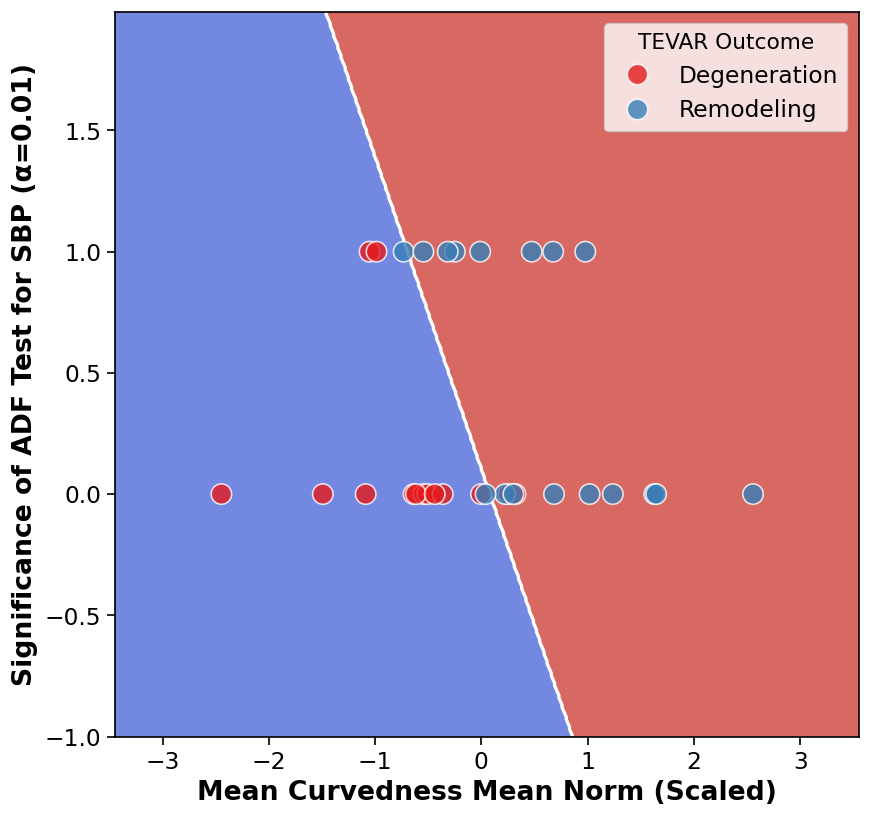

In [59]:
x_min, x_max = X_scaled[:, 0].min() - 1,  X_scaled[:, 0].max() + 1
y_min, y_max =  X_scaled[:, 1].min() - 1,  X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Use the model to predict probabilities on the mesh grid
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predicted probabilities to the shape of the mesh grid
Z = Z.reshape(xx.shape)

# Increase DPI and set figure size
plt.figure(figsize=(8, 8), dpi=120)

cmap_contour = sns.color_palette("coolwarm", as_cmap=True)
cmap_scatter = sns.color_palette("Set1")
decision_boundary = plt.contour(xx, yy, Z, levels=[0.5], colors='white', linewidths=2, zorder=2)


# Plot the contour plot
plt.contourf(xx, yy, Z, cmap=cmap_contour, alpha=0.8, linewidths=2, zorder=1)

# Scatter plot of the data points
scatter = sns.scatterplot(x = X_scaled[:, 0], y= X_scaled[:, 1], hue=y, edgecolors='white', palette='Set1', marker='o', s=150, 
            alpha= 0.8, zorder=3)

# Add labels and title with bigger font sizes
plt.xlabel('Mean Curvedness Mean Norm (Scaled)', fontsize=16, fontweight='bold')
plt.ylabel("Significance of ADF Test for SBP (α=0.01)", fontsize=16,  fontweight='bold')

# Customize the legend
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Degeneration', 'Remodeling'], title='TEVAR Outcome', fontsize=14, title_fontsize='13')

# Increase font size of axis ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


# Add gridlines
plt.grid(False)


# Show the plot
plt.show()

In [60]:
X_features = np.array(X[['Total_Curvature_FluctArea_Norm',  'strict significance of SBP ADF']])

model = LogisticRegression()
cv_predictions = custom_cross_validation(X_features , y, model, cv=5, binary_columns = [1] )


Mean Accuracy: 77.62%


[Text(0, 0.5, 'Actual Degeneration'), Text(0, 1.5, 'Actual Remodeling')]

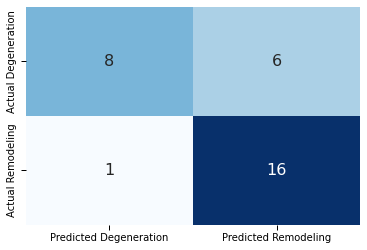

In [61]:
cm  = confusion_matrix(y, cv_predictions)

plot = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Degeneration', 'Predicted Remodeling'],
            yticklabels=['Actual Degeneration', 'Actual Remodeling'], annot_kws={"size": 16})

plot.set_xticklabels(plot.get_xticklabels(), fontsize=10)

# Increase font size of y-axis labels
plot.set_yticklabels(plot.get_yticklabels(), fontsize=10)

Accuracy: 83.87%


[Text(0, 0.5, 'Actual Degeneration'), Text(0, 1.5, 'Actual Remodeling')]

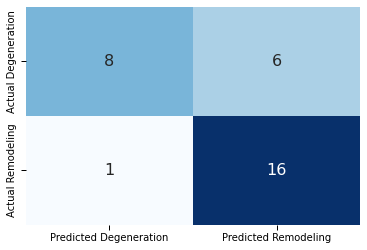

In [62]:
# Define the classifier
classifier = LogisticRegression()

scaler = StandardScaler()


X_scaled = scaler.fit_transform(X_features)
X_scaled[:, 1] = X_features[:, 1]
classifier.fit(X_scaled, y)

pred_y = classifier.predict(X_scaled)

correct_predictions = (y == pred_y).sum()
total_predictions = len(y)
accuracy = correct_predictions / total_predictions

# Display accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

sns.set_context("paper", rc={"font.size":14,"axes.titlesize":16,"axes.labelsize":14})  

cm  = confusion_matrix(y, cv_predictions)

plot = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Degeneration', 'Predicted Remodeling'],
            yticklabels=['Actual Degeneration', 'Actual Remodeling'], annot_kws={"size": 16})

plot.set_xticklabels(plot.get_xticklabels(), fontsize=10)

# Increase font size of y-axis labels
plot.set_yticklabels(plot.get_yticklabels(), fontsize=10)

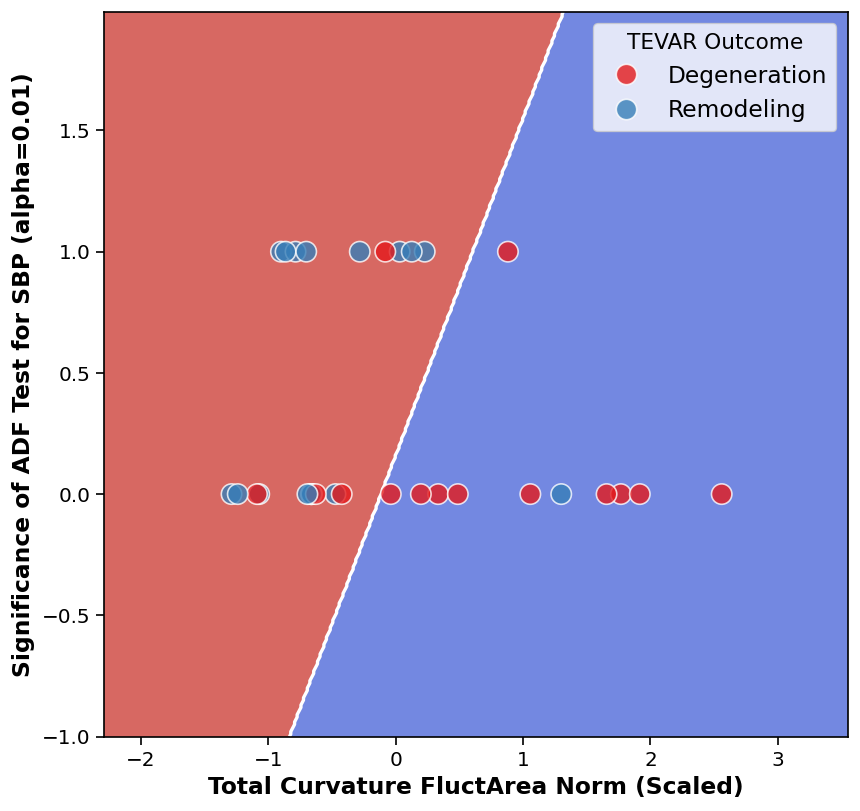

In [63]:
x_min, x_max = X_scaled[:, 0].min() - 1,  X_scaled[:, 0].max() + 1
y_min, y_max =  X_scaled[:, 1].min() - 1,  X_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Use the model to predict probabilities on the mesh grid
Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predicted probabilities to the shape of the mesh grid
Z = Z.reshape(xx.shape)

# Increase DPI and set figure size
plt.figure(figsize=(8, 8), dpi=120)

cmap_contour = sns.color_palette("coolwarm", as_cmap=True)
cmap_scatter = sns.color_palette("Set1")
decision_boundary = plt.contour(xx, yy, Z, levels=[0.5], colors='white', linewidths=2, zorder=2)


# Plot the contour plot
plt.contourf(xx, yy, Z, cmap=cmap_contour, alpha=0.8, linewidths=2, zorder=1)

# Scatter plot of the data points
scatter = sns.scatterplot(x = X_scaled[:, 0], y= X_scaled[:, 1], hue=y, edgecolors='white', palette='Set1', marker='o', s=150, 
            alpha= 0.8, zorder=3)

# Add labels and title with bigger font sizes
plt.xlabel('Total Curvature FluctArea Norm (Scaled)', fontsize=14, fontweight='bold')
plt.ylabel("Significance of ADF Test for SBP (alpha=0.01)", fontsize=14,  fontweight='bold')

# Customize the legend
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Degeneration', 'Remodeling'], title='TEVAR Outcome', fontsize=14, title_fontsize='13')

# Increase font size of axis ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Add gridlines
plt.grid(False)


# Show the plot
plt.show()



In [64]:
X_features = np.array(X[['Mean_Curvedness_Mean_Norm', 'strict significance of SBP ADF', 'Total_Curvature_FluctArea_Norm']])

model = LogisticRegression()
cv_predictions = custom_cross_validation(X_features , y, model, cv=5, binary_columns = None )

Mean Accuracy: 80.95%


[Text(0, 0.5, 'Actual Degeneration'), Text(0, 1.5, 'Actual Remodeling')]

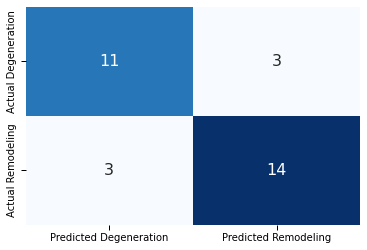

In [65]:
cm  = confusion_matrix(y, cv_predictions)

plot = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Degeneration', 'Predicted Remodeling'],
            yticklabels=['Actual Degeneration', 'Actual Remodeling'], annot_kws={"size": 16})

plot.set_xticklabels(plot.get_xticklabels(), fontsize=10)

# Increase font size of y-axis labels
plot.set_yticklabels(plot.get_yticklabels(), fontsize=10)

Accuracy: 87.10%
Confusion Matrix:


[Text(0, 0.5, 'Actual Degeneration'), Text(0, 1.5, 'Actual Remodeling')]

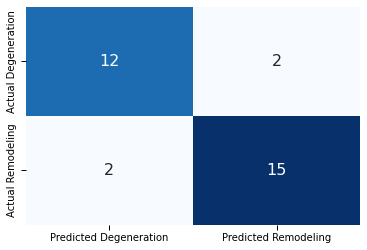

In [66]:
# Define the classifier
classifier = LogisticRegression()

scaler = StandardScaler()


X_scaled = scaler.fit_transform(X_features)
X_scaled[:, 1] = X_features[:, 1]
classifier.fit(X_scaled, y)

pred_y = classifier.predict(X_scaled)

correct_predictions = (y == pred_y).sum()
total_predictions = len(y)
accuracy = correct_predictions / total_predictions

# Display accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

sns.set_context("paper", rc={"font.size":14,"axes.titlesize":16,"axes.labelsize":14})  

cm = confusion_matrix(y, pred_y)
confusion_matrix_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
print("Confusion Matrix:")
plot = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Degeneration', 'Predicted Remodeling'],
            yticklabels=['Actual Degeneration', 'Actual Remodeling'], annot_kws={"size": 16})

plot.set_xticklabels(plot.get_xticklabels(), fontsize=10)

# Increase font size of y-axis labels
plot.set_yticklabels(plot.get_yticklabels(), fontsize=10)


## Final model (Best 5-fold CV accuracy)

In [67]:
X_features = np.array(X[['Mean_Curvedness_Mean_Norm', 'strict significance of SBP ADF' ,'DBP std',  
                         'KPSS SBP', 'Total_Curvature_FluctArea_Norm','ADF PP']])
#X_features = np.array(X[['Mean_Curvedness_Mean_Norm', 'sig_ADF_SBP', 'Total_Curvature_FluctArea_Norm', 'std_DBP', 'ADF_SBP']])

model = LogisticRegression()
cv_predictions = custom_cross_validation(X_features , y, model, cv=5, binary_columns = [1])

Mean Accuracy: 96.67%


[Text(0, 0.5, 'Actual Degeneration'), Text(0, 1.5, 'Actual Remodeling')]

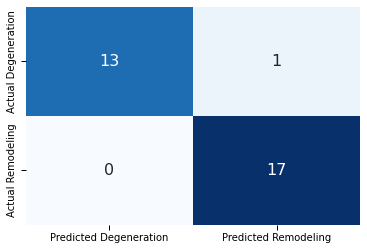

In [68]:
cm  = confusion_matrix(y, cv_predictions)

plot = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Degeneration', 'Predicted Remodeling'],
            yticklabels=['Actual Degeneration', 'Actual Remodeling'], annot_kws={"size": 16})

plot.set_xticklabels(plot.get_xticklabels(), fontsize=10)

# Increase font size of y-axis labels
plot.set_yticklabels(plot.get_yticklabels(), fontsize=10)

Accuracy: 100.00%


[Text(0, 0.5, 'Actual Degeneration'), Text(0, 1.5, 'Actual Remodeling')]

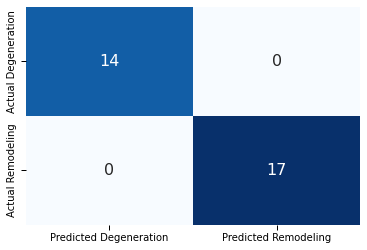

In [69]:
# Define the classifier
classifier = LogisticRegression()

scaler = StandardScaler()


X_scaled = scaler.fit_transform(X_features)
X_scaled[:, 1] = X_features[:, 1]
classifier.fit(X_scaled, y)

pred_y = classifier.predict(X_scaled)

correct_predictions = (y == pred_y).sum()
total_predictions = len(y)
accuracy = correct_predictions / total_predictions

# Display accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

sns.set_context("paper", rc={"font.size":14,"axes.titlesize":16,"axes.labelsize":14})  

cm = confusion_matrix(y, pred_y)
confusion_matrix_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], 
                                   columns=['Predicted Negative', 'Predicted Positive'])


plot = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Degeneration', 'Predicted Remodeling'],
            yticklabels=['Actual Degeneration', 'Actual Remodeling'], annot_kws={"size": 16})

plot.set_xticklabels(plot.get_xticklabels(), fontsize=10)

# Increase font size of y-axis labels
plot.set_yticklabels(plot.get_yticklabels(), fontsize=10)

In [70]:

coefficients = np.abs(classifier.coef_[0])

features = ['Mean_Curvedness_Mean_Norm', 'Total_Curvature_FluctArea_Norm', 'DBP std', 
            'KPSS SBP', 'strict significance of SBP ADF'
           ]


feature_coefficients = list(zip(features, classifier.coef_[0] ,coefficients))

# Sort the list of feature_coefficients based on the absolute coefficients in descending order
sorted_feature_coefficients = sorted(feature_coefficients, key=lambda x: x[2], reverse=True)

# Print the sorted feature names and their corresponding scores
print("Sorted Features by Importance:")
for index, score, coef in sorted_feature_coefficients:
    print(f"{index}: Score = {score}")



Sorted Features by Importance:
Mean_Curvedness_Mean_Norm: Score = 1.38352111709098
Total_Curvature_FluctArea_Norm: Score = 1.2344908345051568
strict significance of SBP ADF: Score = -0.8454478938435473
DBP std: Score = 0.8262263489992308
KPSS SBP: Score = 0.8081301685593715


In [71]:
correlation_matrix = patients_df[features + ['y']].corr(method='pearson')

target_correlations = correlation_matrix['y'].drop('y')

In [72]:

target_correlations 

Mean_Curvedness_Mean_Norm         0.622444
Total_Curvature_FluctArea_Norm   -0.557313
DBP std                           0.329569
KPSS SBP                          0.300359
strict significance of SBP ADF    0.348896
Name: y, dtype: float64

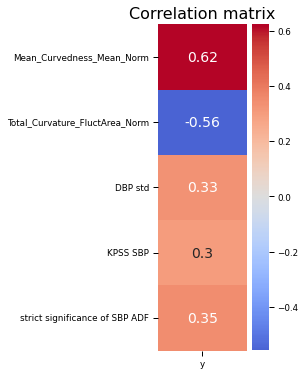

In [73]:
plt.figure(figsize=(2, 6))
sns.heatmap(target_correlations.to_frame(), annot=True, cmap='coolwarm', center=0)

plt.title(f'Correlation matrix')
plt.show()

## Plot stationary vs non stationary data

In [74]:
bad_non_stationary = patients_df[(patients_df['y'] == 0) & (patients_df['strict significance of SBP ADF'] == 0)]
good_non_stationary = patients_df[(patients_df['y'] == 1) & (patients_df['strict significance of SBP ADF'] == 0)]
bad_stationary = patients_df[(patients_df['y'] == 0) & (patients_df['strict significance of SBP ADF'] == 1)]
good_stationary = patients_df[(patients_df['y'] == 1) & (patients_df['strict significance of SBP ADF'] == 1)]


<Figure size 720x432 with 0 Axes>

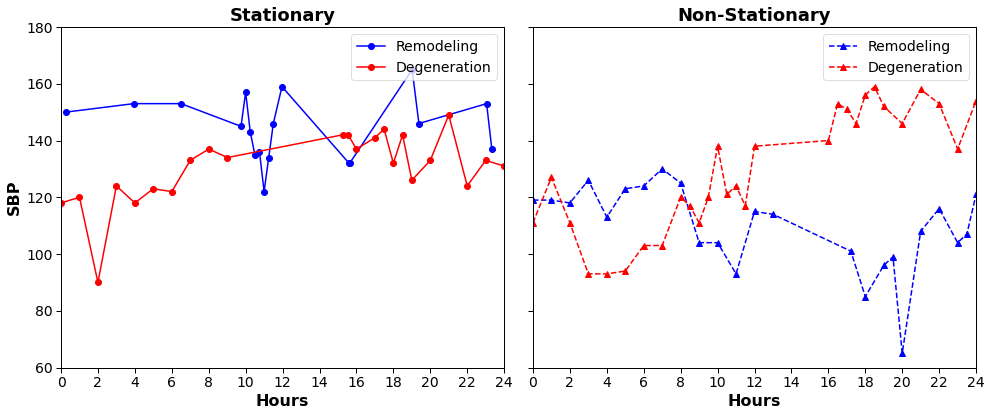

In [75]:
# Example data setup (replace with your actual data retrieval)
# Assuming bad_non_stationary is your dataframe and index_value is the specific index value you're interested in
index_value = 'KK2'  # Replace with the index value you want to plot
selected_columns = ['Column1', 'Column2']  # Replace with your selected columns

# Extract data for the specific index_value
df1 = bad_non_stationary.loc['KK2', 'data']
df2 = bad_non_stationary.loc['KK6', 'data']
df3 = good_non_stationary.loc['KK19', 'data']
df4 = good_stationary.loc['KK41', 'data']
df5 = bad_stationary.loc['KK26', 'data']


# Plot using Seaborn
plt.figure(figsize=(10, 6))  # Adjust size as needed

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)


ax1.plot(df4['Relative Date']*24 , df4['SBP'], marker='o',markersize=6, linewidth=1.5, label="Remodeling",
         c='blue')
ax1.plot(df5['Relative Date']*24, df5['SBP'], marker='o',markersize=6, linewidth=1.5, label="Degeneration", c='red') 


#plt.plot(df2['Relative Date'], df2['SBP'] marker='o', linewidth=1, label="non stationary degeneration", c='red')

ax1.set_xlabel('Hours',fontsize=16, fontweight='bold')
ax1.set_ylabel('SBP', fontsize=16, fontweight='bold')
ax1.set_title('Stationary', fontsize=18,  fontweight='bold')
ax1.legend(fontsize=14, loc='upper right')


ax1.tick_params(axis='x', labelsize=14)  # Increase font size of x ticks
ax1.tick_params(axis='y', labelsize=14)  # Increase font size of y ticks

ax1.set_xlim(0, 24)  # Set x-axis limit from 0 to 12 hours
ax1.set_xticks(range(0, 25, 2))  # Set x-axis ticks every 2 hours from 0 to 12

ax1.set_ylim(60, 210)  # Set x-axis limit from 0 to 12 hours
ax1.set_yticks(range(40, 220, 20))  # Set x-axis ticks every 2 hours from 0 to 12

ax2.plot(df3['Relative Date'] *24, df3['SBP'], marker='^',markersize=6, linewidth=1.5, label="Remodeling", 
         c='blue', linestyle='--')
ax2.plot(df1['Relative Date']*24, df1['SBP'], marker='^',markersize=6, linewidth=1.5, label="Degeneration", c='red', 
          linestyle='--')

            


ax2.set_xlabel('Hours',fontsize=16, fontweight='bold')
#ax2.set_ylabel('SBP', fontsize=16, fontweight='bold')
ax2.set_title('Non-Stationary', fontsize=18, fontweight='bold')
ax2.legend(fontsize=14, loc='upper right')


ax2.tick_params(axis='x', labelsize=14)  # Increase font size of x ticks
ax2.tick_params(axis='y', labelsize=14)  # Increase font size of y ticks

ax2.set_xlim(0, 24)  # Set x-axis limit from 0 to 12 hours
ax2.set_xticks(range(0, 25, 2))  # Set x-axis ticks every 2 hours from 0 to 12

ax2.set_ylim(60, 210)  # Set x-axis limit from 0 to 12 hours
ax2.set_yticks(range(40, 220, 20))  # Set x-axis ticks every 2 hours from 0 to 12



plt.ylim(60, 180)  # Set x-axis limit from 0 to 24

plt.grid(False)  # Add gridlines
#sns.despine()  # Remove top and right spines

plt.tight_layout()  # Adjust layout for better spacing

plt.show()

<Figure size 720x432 with 0 Axes>

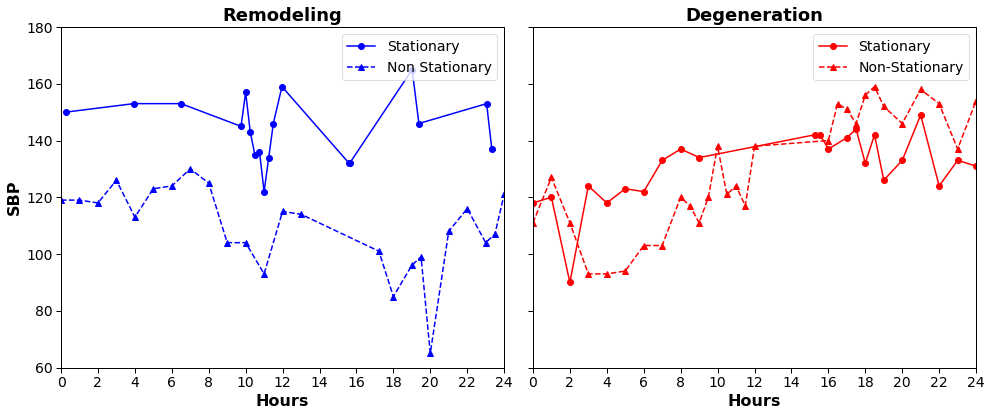

In [76]:
# Example data setup (replace with your actual data retrieval)
# Assuming bad_non_stationary is your dataframe and index_value is the specific index value you're interested in
index_value = 'KK2'  # Replace with the index value you want to plot
selected_columns = ['Column1', 'Column2']  # Replace with your selected columns

# Extract data for the specific index_value
df1 = bad_non_stationary.loc['KK2', 'data']
df2 = bad_non_stationary.loc['KK6', 'data']
df3 = good_non_stationary.loc['KK19', 'data']
df4 = good_stationary.loc['KK41', 'data']
df5 = bad_stationary.loc['KK26', 'data']


# Plot using Seaborn
plt.figure(figsize=(10, 6))  # Adjust size as needed

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

ax1.plot(df4['Relative Date']*24 , df4['SBP'], marker='o',markersize=6, linewidth=1.5, label="Stationary",
         c='blue')

ax1.plot(df3['Relative Date'] *24, df3['SBP'], marker='^',markersize=6, linewidth=1.5, label="Non Stationary", 
         c='blue', linestyle='--')


ax1.set_xlabel('Hours',fontsize=16, fontweight='bold')
ax1.set_ylabel('SBP', fontsize=16, fontweight='bold')
ax1.set_title('Remodeling', fontsize=18,  fontweight='bold')
ax1.legend(fontsize=14, loc='upper right')


ax1.tick_params(axis='x', labelsize=14)  # Increase font size of x ticks
ax1.tick_params(axis='y', labelsize=14)  # Increase font size of y ticks

ax1.set_xlim(0, 24)  # Set x-axis limit from 0 to 12 hours
ax1.set_xticks(range(0, 25, 2))  # Set x-axis ticks every 2 hours from 0 to 12

ax1.set_ylim(60, 210)  # Set x-axis limit from 0 to 12 hours
ax1.set_yticks(range(40, 220, 20))  # Set x-axis ticks every 2 hours from 0 to 12


ax2.plot(df5['Relative Date']*24, df5['SBP'], marker='o',markersize=6, linewidth=1.5, label="Stationary", c='red')
ax2.plot(df1['Relative Date']*24, df1['SBP'], marker='^',markersize=6, linewidth=1.5, label="Non-Stationary", c='red', 
         linestyle='--')
#plt.plot(df2['Relative Date'], df2['SBP'] marker='o', linewidth=1, label="non stationary degeneration", c='red')



ax2.set_xlabel('Hours',fontsize=16, fontweight='bold')
#ax2.set_ylabel('SBP', fontsize=16, fontweight='bold')
ax2.set_title('Degeneration', fontsize=18, fontweight='bold')
ax2.legend(fontsize=14, loc='upper right')


ax2.tick_params(axis='x', labelsize=14)  # Increase font size of x ticks
ax2.tick_params(axis='y', labelsize=14)  # Increase font size of y ticks

ax2.set_xlim(0, 24)  # Set x-axis limit from 0 to 12 hours
ax2.set_xticks(range(0, 25, 2))  # Set x-axis ticks every 2 hours from 0 to 12

ax2.set_ylim(60, 210)  # Set x-axis limit from 0 to 12 hours
ax2.set_yticks(range(40, 220, 20))  # Set x-axis ticks every 2 hours from 0 to 12



plt.ylim(60, 180)  # Set x-axis limit from 0 to 24

plt.grid(False)  # Add gridlines
#sns.despine()  # Remove top and right spines

plt.tight_layout()  # Adjust layout for better spacing

plt.show()

In [77]:
len(patients_df)

31

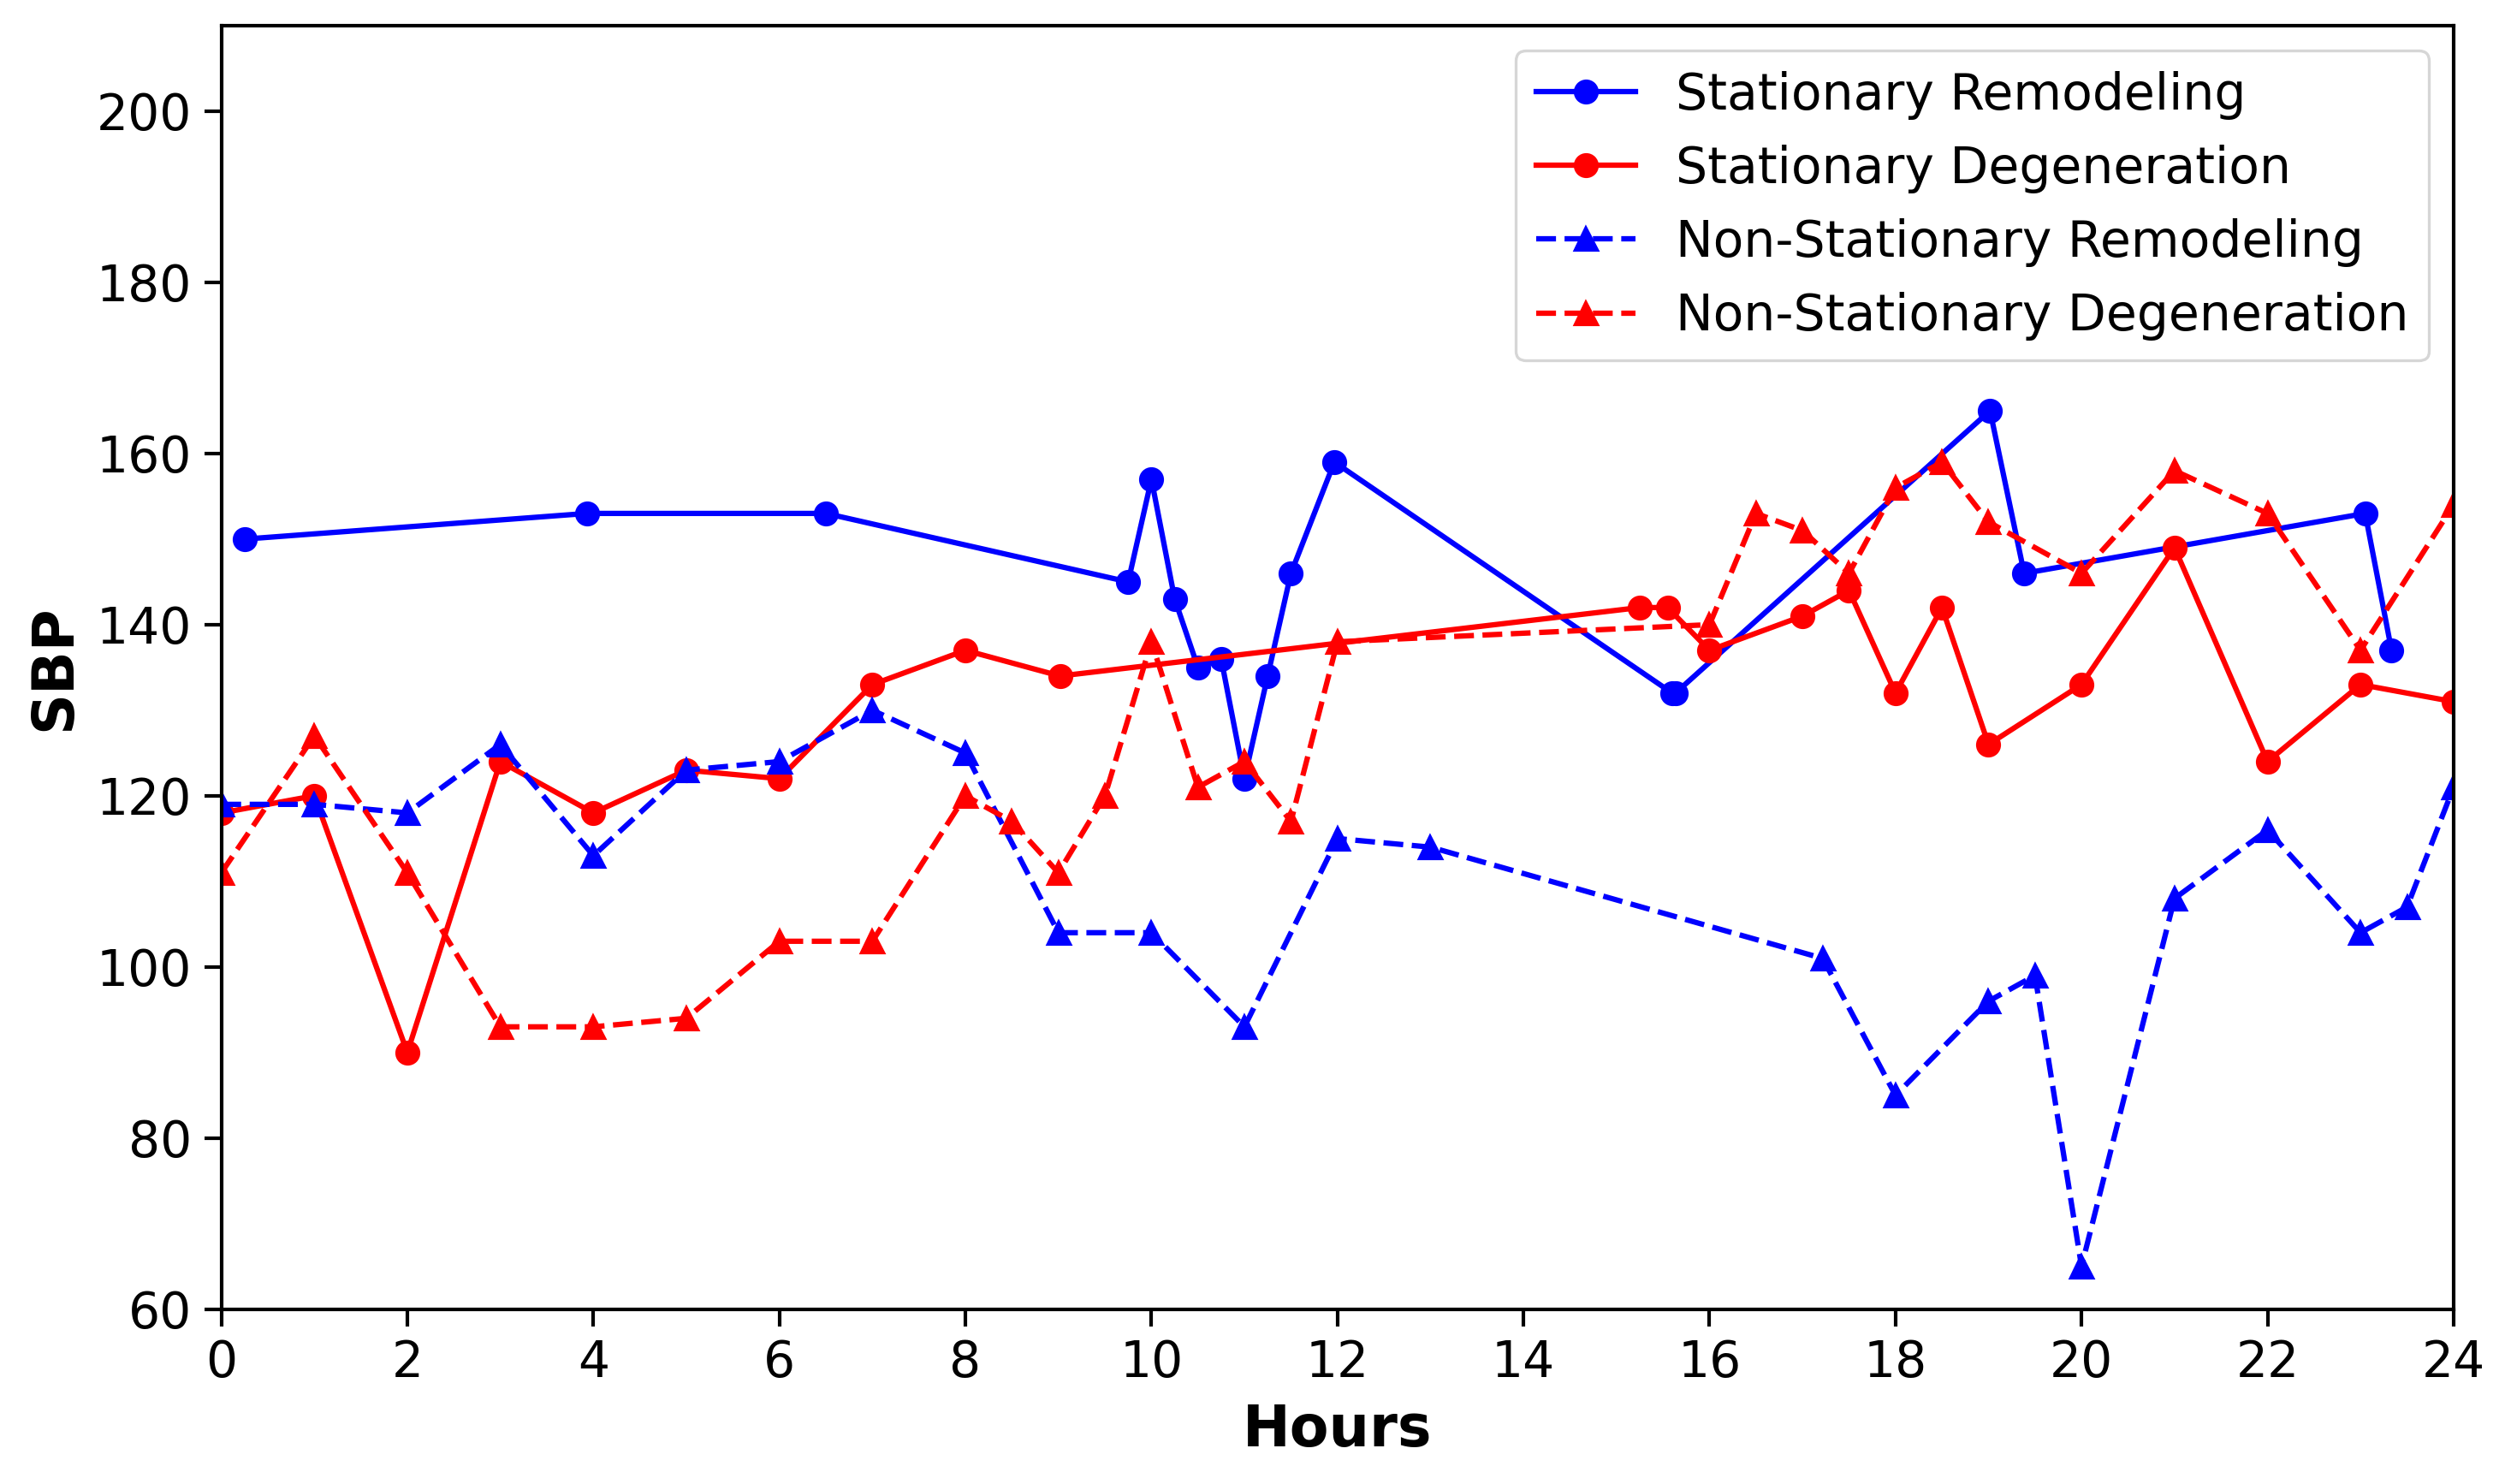

In [78]:
# Example data setup (replace with your actual data retrieval)
# Assuming bad_non_stationary is your dataframe and index_value is the specific index value you're interested in
index_value = 'KK2'  # Replace with the index value you want to plot
selected_columns = ['Column1', 'Column2']  # Replace with your selected columns

# Extract data for the specific index_value
df1 = bad_non_stationary.loc['KK2', 'data']
df2 = bad_non_stationary.loc['KK6', 'data']
df3 = good_non_stationary.loc['KK19', 'data']
df4 = good_stationary.loc['KK41', 'data']
df5 = bad_stationary.loc['KK26', 'data']


# Plot using Seaborn
plt.figure(figsize=(10, 6), dpi= 300)  # Adjust size as needed



plt.plot(df4['Relative Date']*24 , df4['SBP'], marker='o',markersize=6, linewidth=1.5, label="Stationary Remodeling", c='blue')
plt.plot(df5['Relative Date']*24, df5['SBP'], marker='o',markersize=6, linewidth=1.5, label="Stationary Degeneration", c='red')

plt.plot(df3['Relative Date'] *24, df3['SBP'], marker='^',markersize=6, linewidth=1.5, label="Non-Stationary Remodeling", 
         c='blue', linestyle='--')
plt.plot(df1['Relative Date']*24, df1['SBP'], marker='^',markersize=6, linewidth=1.5, label="Non-Stationary Degeneration", 
         c='red', linestyle='--')
#plt.plot(df2['Relative Date'], df2['SBP'] marker='o', linewidth=1, label="non stationary degeneration", c='red')

plt.xlabel('Hours',  fontsize=16, fontweight='bold')
plt.ylabel('SBP', fontsize=16, fontweight='bold')
#plt.title('Line Plot of SBP Over Time', fontsize=16)

plt.legend(fontsize=14, loc='upper right')  # Show legend with adjusted font size and location

plt.xticks(range(0, 25, 2), fontsize=14, )  # Set x-axis ticks every 3 hours from 0 to 24
plt.xlim(0, 24)  # Set x-axis limit from 0 to 24

plt.yticks(range(40, 220, 20), fontsize=14)  # Set x-axis ticks every 3 hours from 0 to 24
plt.ylim(60, 210)  # Set x-axis limit from 0 to 24

plt.grid(False)  # Add gridlines
#sns.despine()  # Remove top and right spines

plt.tight_layout()  # Adjust layout for better spacing

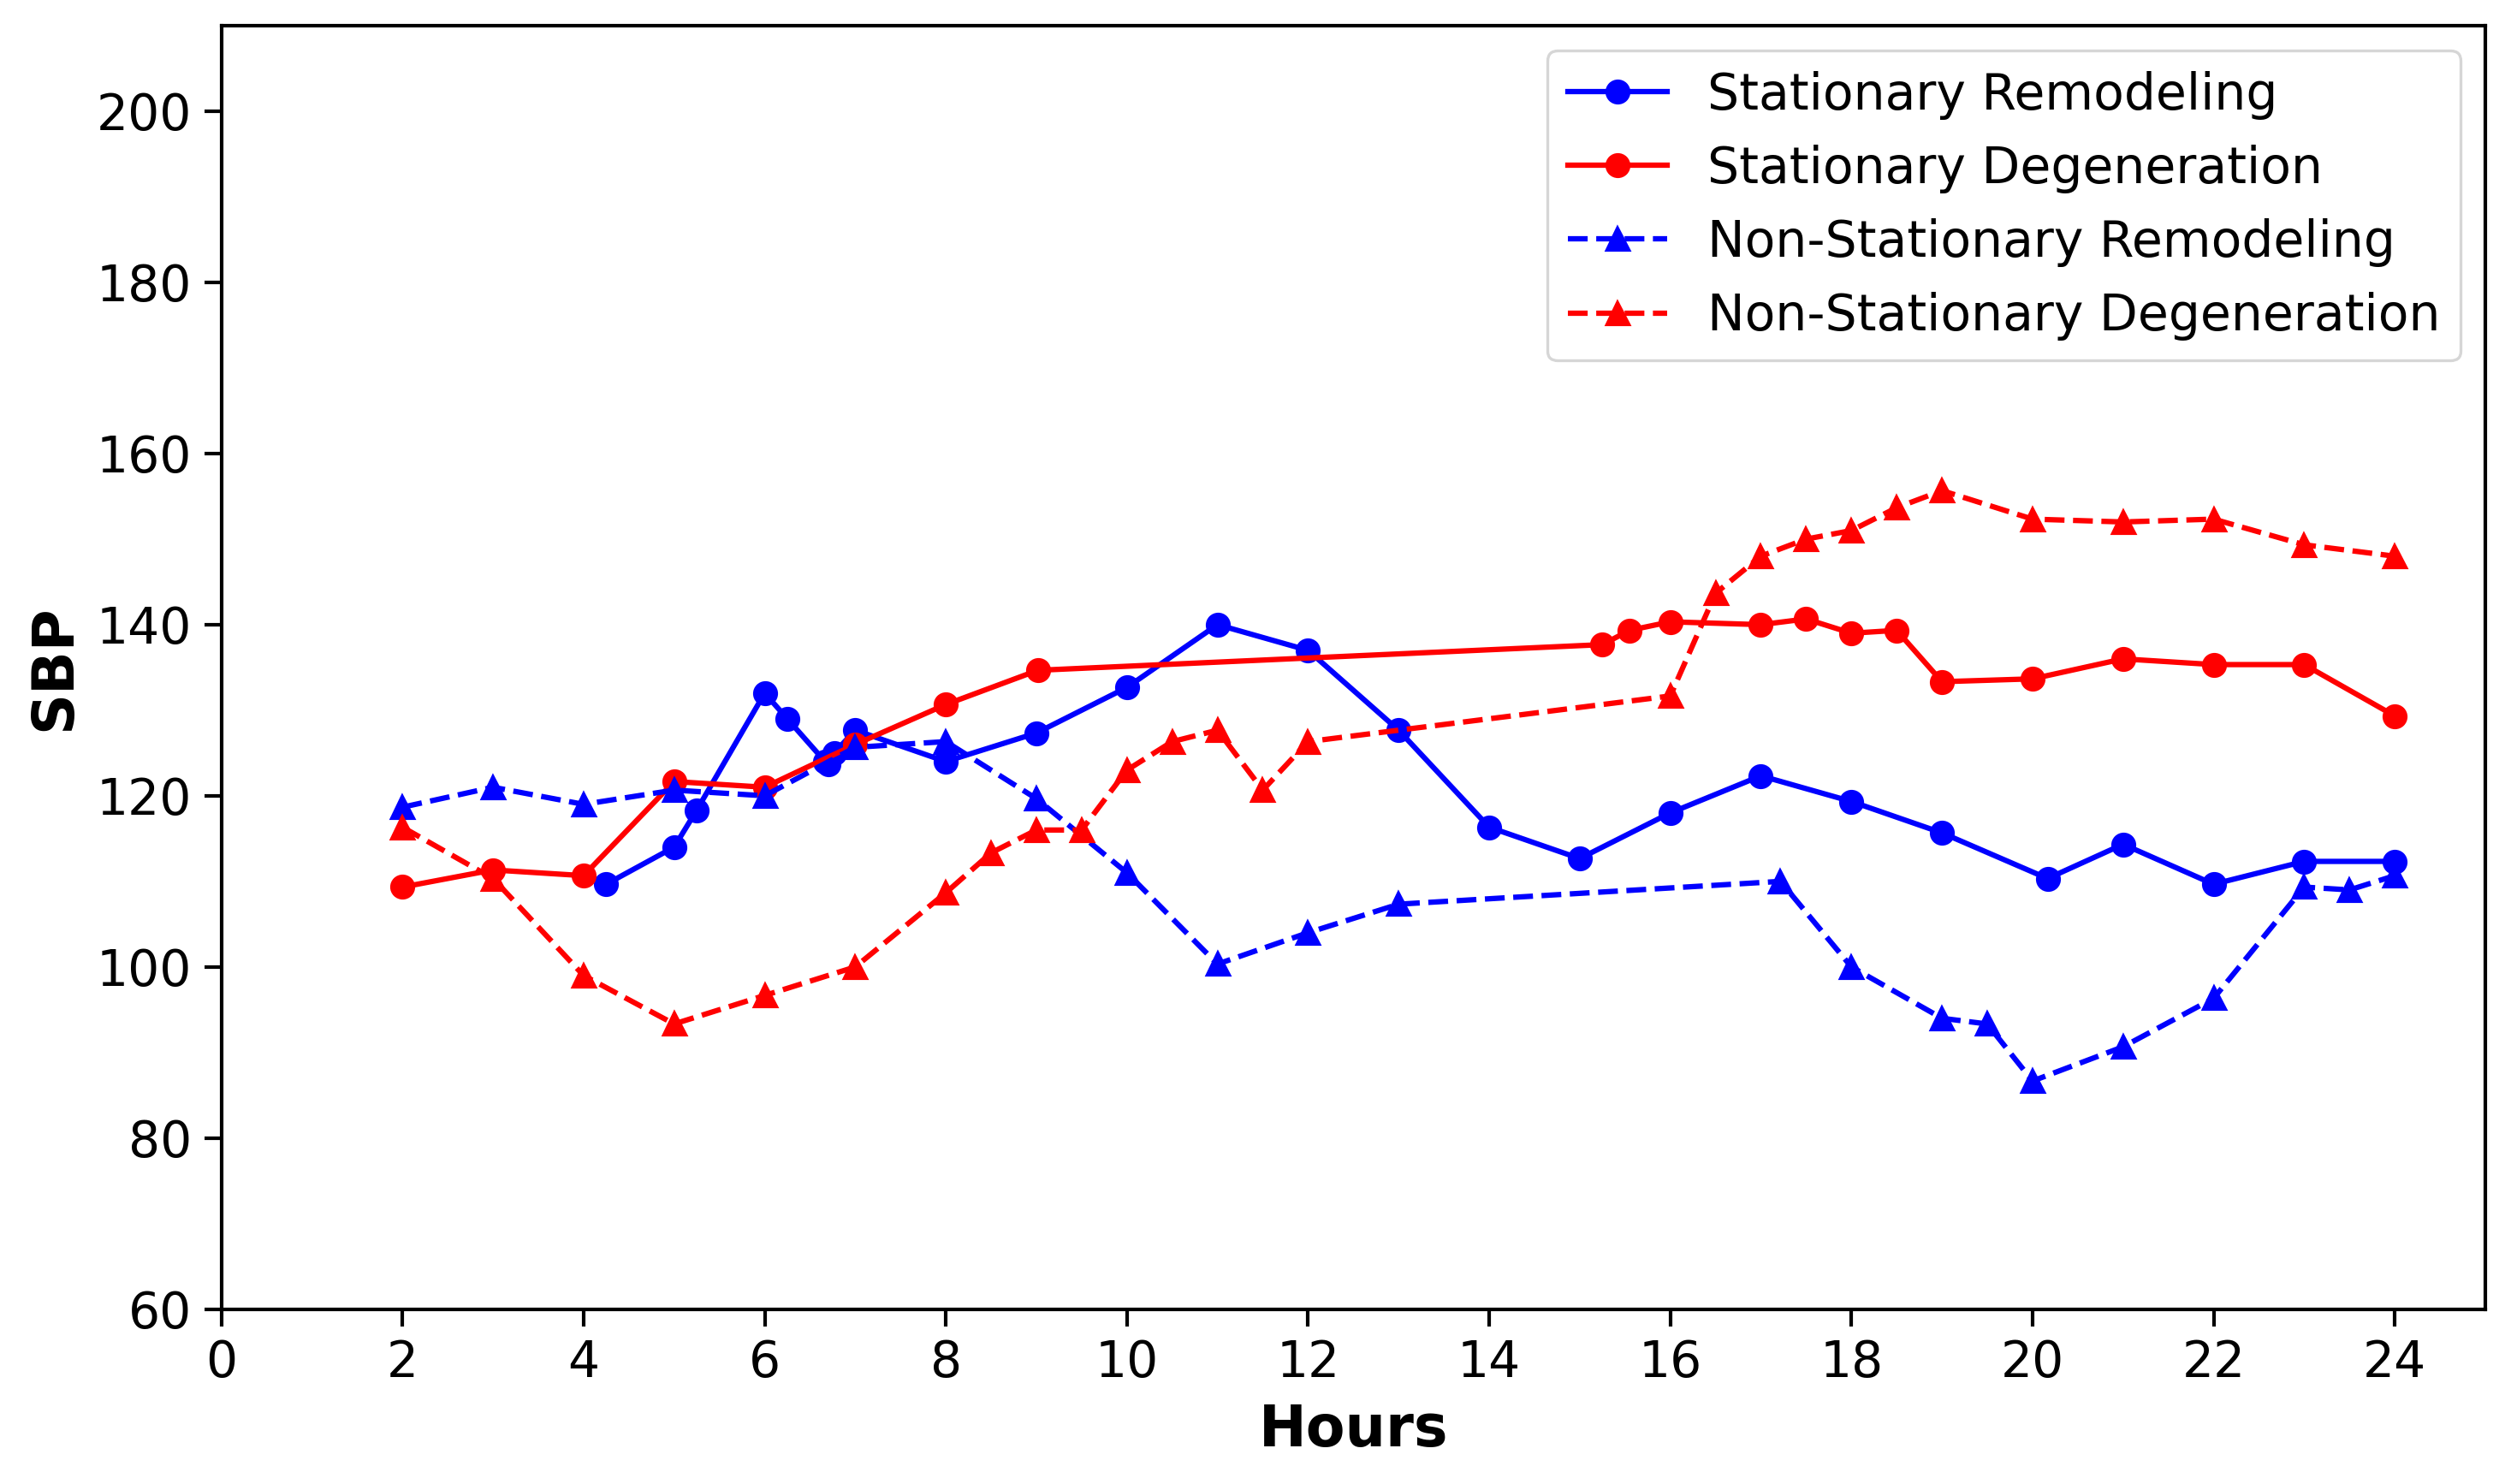

In [79]:
# Example data setup (replace with your actual data retrieval)
# Assuming bad_non_stationary is your dataframe and index_value is the specific index value you're interested in
index_value = 'KK2'  # Replace with the index value you want to plot
selected_columns = ['Column1', 'Column2']  # Replace with your selected columns

# Extract data for the specific index_value
df1 = bad_non_stationary.loc['KK2', 'data']
df2 = bad_non_stationary.loc['KK6', 'data']
df3 = good_non_stationary.loc['KK19', 'data']
df4 = good_stationary.loc['KK27', 'data']
df5 = bad_stationary.loc['KK26', 'data']


# Plot using Seaborn
plt.figure(figsize=(10, 6),  dpi=300)  # Adjust size as needed



plt.plot(df4['Relative Date']*24 , df4['SBP'].rolling(window=3).mean(), marker='o',markersize=6, linewidth=1.5, 
         label="Stationary Remodeling", c='blue')
plt.plot(df5['Relative Date']*24, df5['SBP'].rolling(window=3).mean(), marker='o',markersize=6, linewidth=1.5, 
         label="Stationary Degeneration", c='red')

plt.plot(df3['Relative Date'] *24, df3['SBP'].rolling(window=3).mean(), marker='^',markersize=6, linewidth=1.5, 
         label="Non-Stationary Remodeling", 
         c='blue', linestyle='--')
plt.plot(df1['Relative Date']*24, df1['SBP'].rolling(window=3).mean(), marker='^',markersize=6, linewidth=1.5, 
         label="Non-Stationary Degeneration", 
         c='red', linestyle='--')
#plt.plot(df2['Relative Date'], df2['SBP'] marker='o', linewidth=1, label="non stationary degeneration", c='red')

plt.xlabel('Hours',  fontsize=16, fontweight='bold')
plt.ylabel('SBP', fontsize=16, fontweight='bold')
#plt.title('Line Plot of SBP Over Time', fontsize=16)

plt.legend(fontsize=14, loc='upper right')  # Show legend with adjusted font size and location

plt.xticks(range(0, 27, 2), fontsize=14, )  # Set x-axis ticks every 3 hours from 0 to 24
plt.xlim(0, 25)  # Set x-axis limit from 0 to 24

plt.yticks(range(40, 220, 20), fontsize=14)  # Set x-axis ticks every 3 hours from 0 to 24
plt.ylim(60, 210)  # Set x-axis limit from 0 to 24

plt.grid(False)  # Add gridlines
#sns.despine()  # Remove top and right spines

plt.tight_layout()  # Adjust layout for better spacing

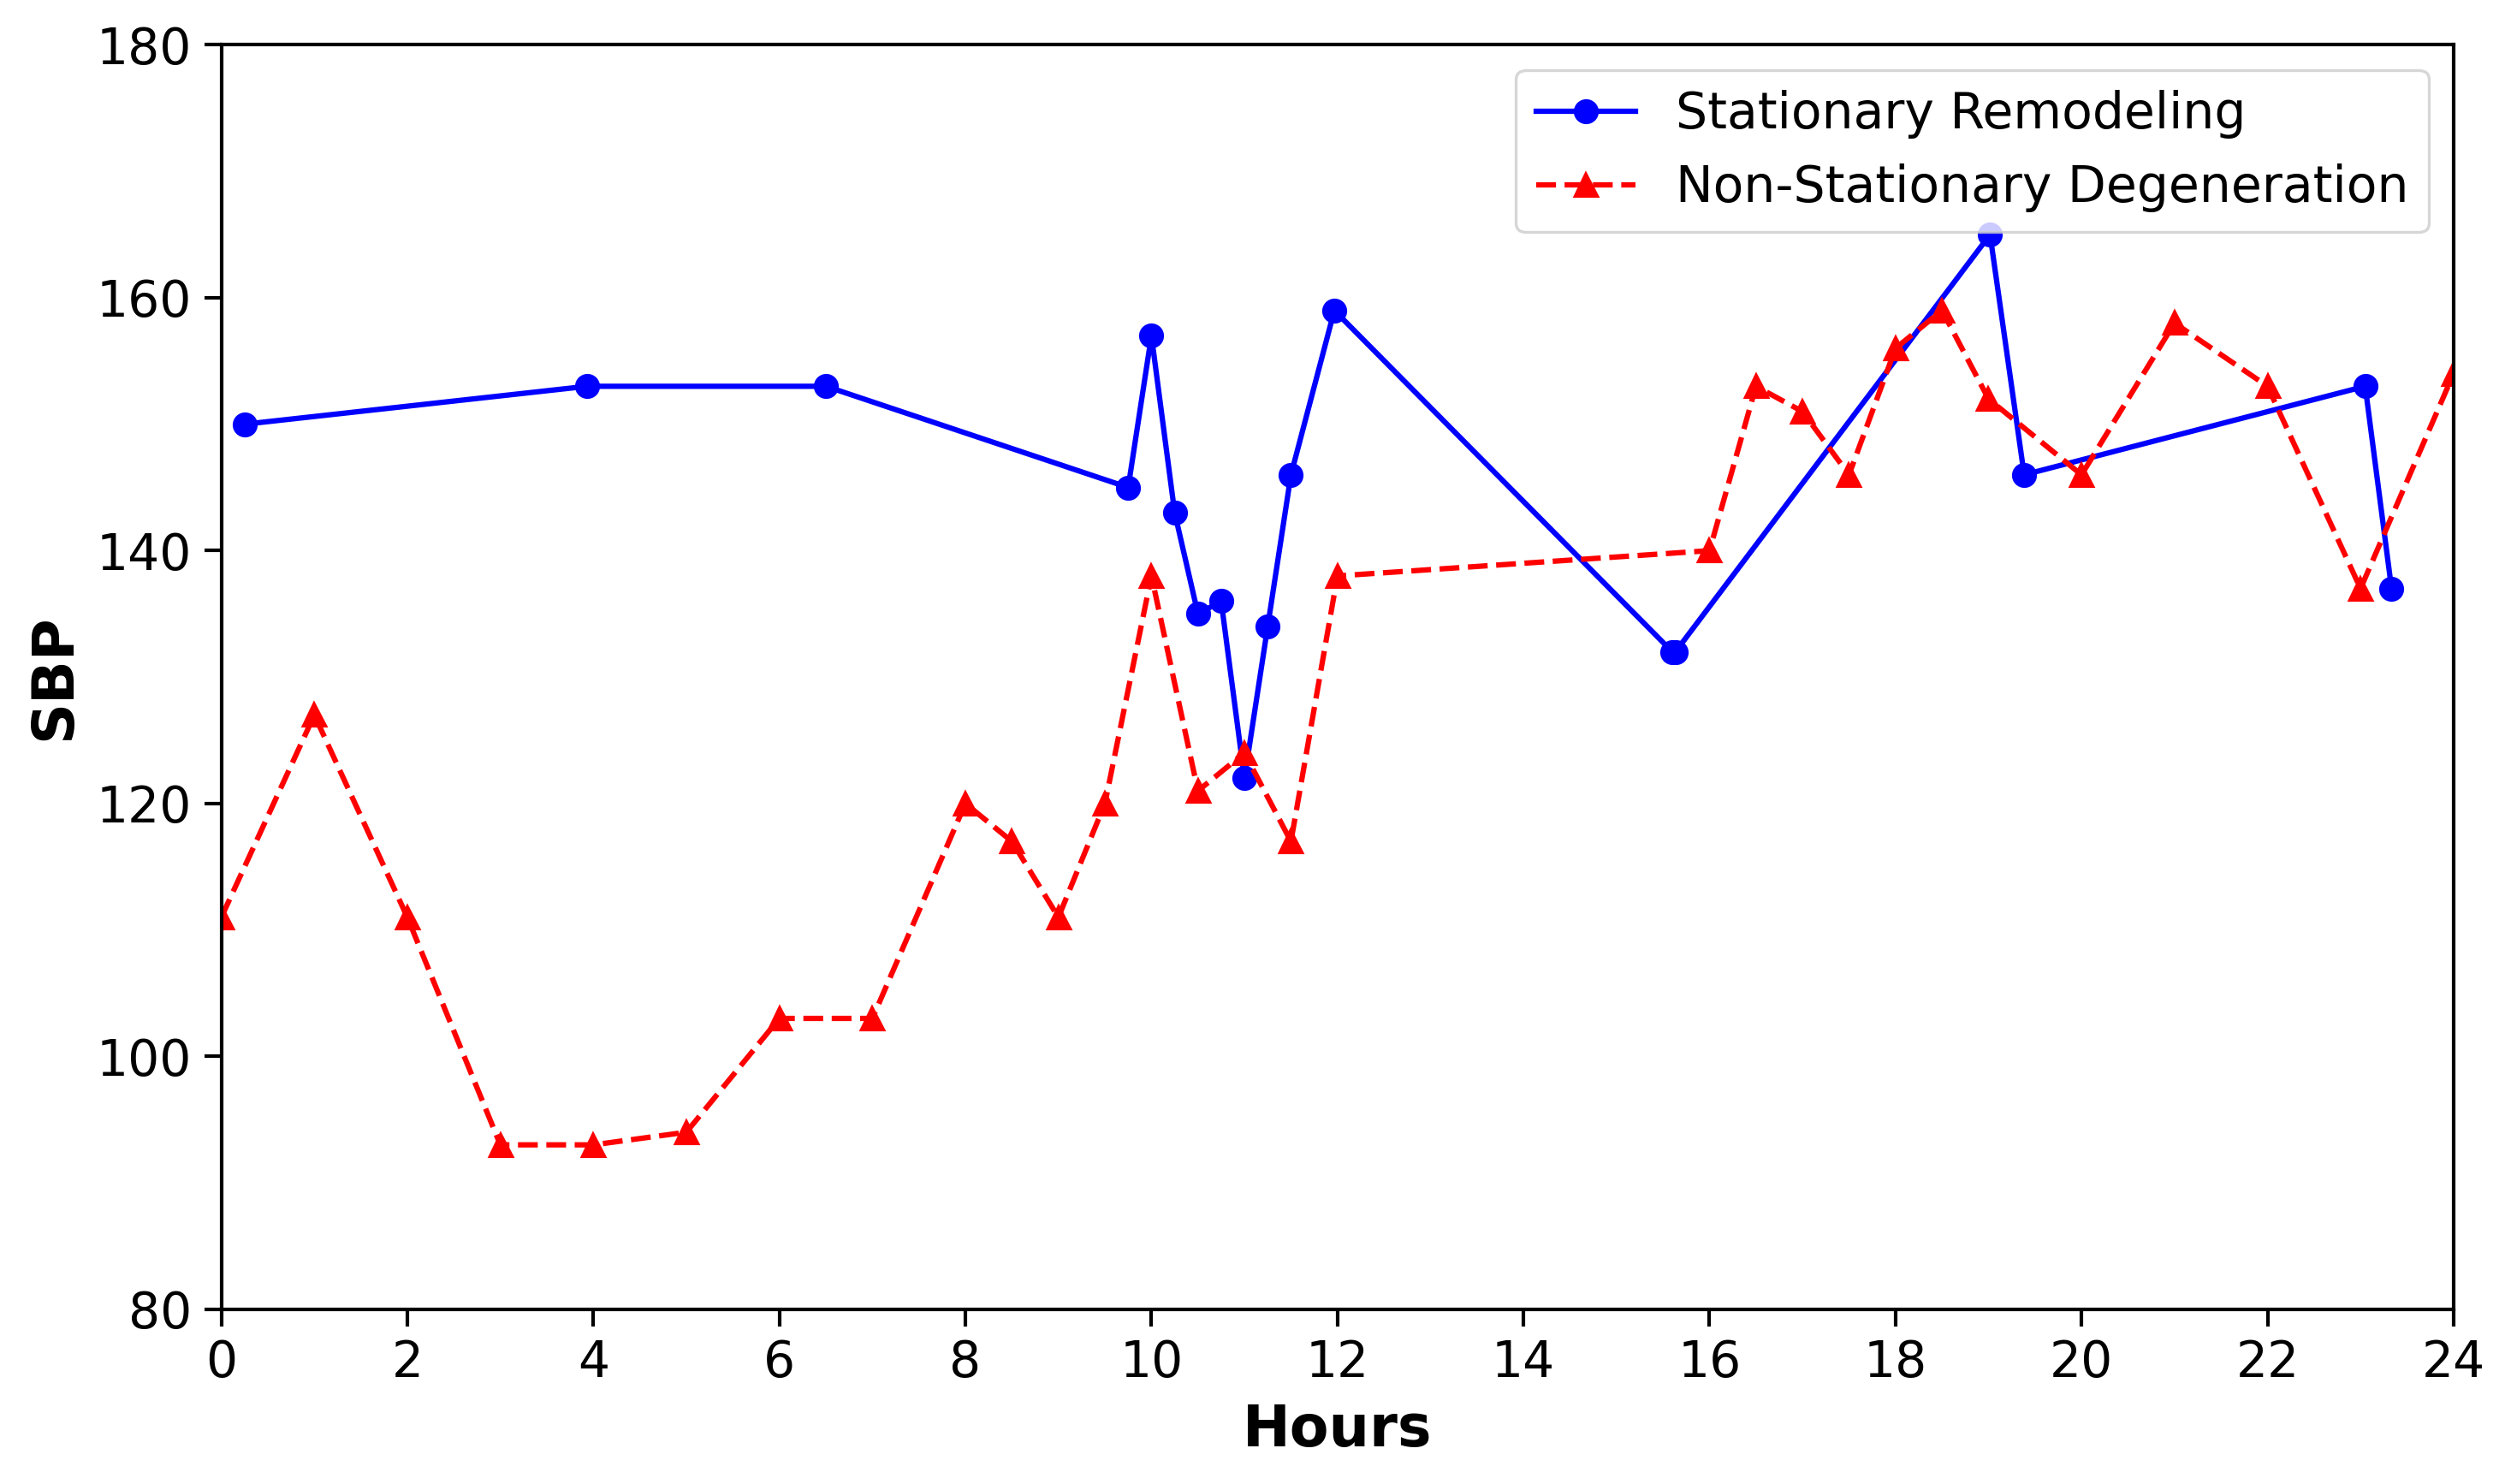

In [80]:
# Example data setup (replace with your actual data retrieval)
# Assuming bad_non_stationary is your dataframe and index_value is the specific index value you're interested in
index_value = 'KK2'  # Replace with the index value you want to plot
selected_columns = ['Column1', 'Column2']  # Replace with your selected columns

# Extract data for the specific index_value
df1 = bad_non_stationary.loc['KK2', 'data']
df2 = bad_non_stationary.loc['KK6', 'data']
df3 = good_non_stationary.loc['KK19', 'data']
df4 = good_stationary.loc['KK41', 'data']
df5 = bad_stationary.loc['KK26', 'data']


# Plot using Seaborn
plt.figure(figsize=(10, 6), dpi=300)  # Adjust size as needed



plt.plot(df4['Relative Date']*24 , df4['SBP'], marker='o',markersize=6, linewidth=1.5, label="Stationary Remodeling", c='blue')


plt.plot(df1['Relative Date']*24, df1['SBP'], marker='^',markersize=6, linewidth=1.5, label="Non-Stationary Degeneration", 
         c='red', linestyle='--')
#plt.plot(df2['Relative Date'], df2['SBP'] marker='o', linewidth=1, label="non stationary degeneration", c='red')

plt.xlabel('Hours',  fontsize=16, fontweight='bold')
plt.ylabel('SBP', fontsize=16, fontweight='bold')
#plt.title('Line Plot of SBP Over Time', fontsize=16)

plt.legend(fontsize=14, loc='upper right')  # Show legend with adjusted font size and location

plt.xticks(range(0, 25, 2), fontsize=14, )  # Set x-axis ticks every 3 hours from 0 to 24
plt.xlim(0, 24)  # Set x-axis limit from 0 to 24

plt.yticks(range(40, 220, 20), fontsize=14)  # Set x-axis ticks every 3 hours from 0 to 24
plt.ylim(80, 180)  # Set x-axis limit from 0 to 24

plt.grid(False)  # Add gridlines
#sns.despine()  # Remove top and right spines

plt.tight_layout()  # Adjust layout for better spacing